# Выпускной проект: "Телекоммуникации"

## Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Наша задача — обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг**:

Оператор предоставляет **два основных типа услуг**: 
- **Стационарную телефонную связь**. Телефон можно подключить к нескольким линиям одновременно.
- **Интернет**. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

**Описание данных**:

1. Файл `contract_new.csv` содержит информацию о договоре. Описание данных:
    - `customerID` — идентификатор абонента;
    - `BeginDate` — дата начала действия договора;
    - `EndDate` — дата окончания действия договора;
    - `Type` — тип оплаты: раз в год-два или ежемесячно;
    - `PaperlessBilling` — электронный расчётный лист;
    - `PaymentMethod` — тип платежа;
    - `MonthlyCharges` — расходы за месяц;
    - `TotalCharges` — общие расходы абонента.


2. Файл `personal_new.csv` содержит персональные данные клиентов. Описание данных:
    - `customerID` — идентификатор пользователя;
    - `gender` — пол;
    - `SeniorCitizen` — является ли абонент пенсионером;
    - `Partner` — есть ли у абонента супруг или супруга;
    - `Dependents` — есть ли у абонента дети.


3. Файл `internet_new.csv` содержит информацию об интернет-услугах. Описание данных:
    - `customerID` — идентификатор пользователя;
    - `InternetService` — тип подключения;
    - `OnlineSecurity` — блокировка опасных сайтов;
    - `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
    - `DeviceProtection` — антивирус;
    - `TechSupport` — выделенная линия технической поддержки;
    - `StreamingTV` — стриминговое телевидение;
    - `StreamingMovies` — каталог фильмов.


4. Файл `phone_new.csv` содержит информацию об услугах телефонии. Описание данных:
    - `customerID` — идентификатор пользователя;
    - `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

**План работы над задачей:**

1) **Загрузим и изучим данные** на предмет возникновения в них дубликатов, пропусков и ошибок в типах данных.

2) **На этапе исследовательского анализа и предобработки данных** обработаем все недостатки исходных данных, найденные на предыдущем шаге, а также детальнее ознакомимся с данными и сделаем предварительные выводы о возможных причинах оттока клиентов. 

3) **В рамках корреляционного анализа** изучим взаимосвязи между признаками, которые впоследствии используем в машинном обучении.

4) **Подготовим данные для обучения,** выполнив подготовку признаков в пайплайне; подготовим функцию для обучения моделей.

5) **Обучим модели** логистической регрессии, метода опорных векторов и k-ближайших соседей, алгоритмы деревьев решений и градиентного бустинга.

6) **Выберем лучшую модель** по итогам кросс-валидации и обучим её на тестовой выборке.

7) **Построим матрицу ошибок** для изучения количества ошибок второго рода и потенциальной корректировки модели.

8) **Проведём анализ важности признаков** с целью изучения степени их влияния на итоговое предсказание, и найдём те из них, которые вносят наибольший и наименьший вклад.

9) **Сделаем итоговый вывод** об основных итогах исследования, предложим заказчику лучшую модель и ряд рекомендаций по снижению оттока клиентов. 

In [1]:
!pip install phik -q
!pip install shap -q
!pip install catboost -q
!pip install lightgbm -q

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import catboost
import phik
import shap
import os
import re

from scipy import stats as st
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
)
    
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from lightgbm import LGBMClassifier

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rcParams, rcParamsDefault
rcParams['figure.figsize'] = 10, 6
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

def describe_data (data): # Заранее пропишем функцию для ознакомления с датасетами
    print('Первые пять строк таблицы:')
    display(data.head())
    print('\n', 'Последние пять строк таблицы:')
    display(data.tail())
    print('\n', 'Общая информация о датасете:', '\n')
    data.info()
    print('\n', 'Описательные статистики датасета:')
    display(data.describe(include='all').round(2))
    print('\n', 'Количество пропусков в данных:')
    display(data.isna().sum())

def plot_describe (t, x_l, y_l): # Также заранее пропишем функцию, подписывающую название графика и осей
    plt.title(t)                 
    plt.xlabel(x_l)              
    plt.ylabel(y_l)              
    plt.show()    
    
RANDOM_STATE = 140725
TEST_SIZE = 0.25

## Загрузка данных

Считаем csv-файлы:

In [3]:
pth1 = 'C:/pr/pr_13/contract_new.csv' 
pth2 = '/datasets/contract_new.csv'
pth3 = 'C:/pr/pr_13/personal_new.csv' 
pth4 = '/datasets/personal_new.csv'
pth5 = 'C:/pr/pr_13/internet_new.csv'
pth6 = '/datasets/internet_new.csv'
pth7 = 'C:/pr/pr_13/phone_new.csv'
pth8 = '/datasets/phone_new.csv'

if os.path.exists(pth1):
    df_contract = pd.read_csv(pth1, index_col=0, parse_dates=[1])
elif os.path.exists(pth2):
    df_contract = pd.read_csv(pth2, index_col=0, parse_dates=[1])
else:
    print('Something is wrong')

if os.path.exists(pth3):
    df_personal = pd.read_csv(pth3, index_col=0)
elif os.path.exists(pth4):
    df_personal = pd.read_csv(pth4, index_col=0)
else:
    print('Something is wrong')

if os.path.exists(pth5):
    df_internet = pd.read_csv(pth5, index_col=0)
elif os.path.exists(pth6):
    df_internet = pd.read_csv(pth6, index_col=0)
else:
    print('Something is wrong')
    
if os.path.exists(pth7):
    df_phone = pd.read_csv(pth7, index_col=0)
elif os.path.exists(pth8):
    df_phone = pd.read_csv(pth8, index_col=0)
else:
    print('Something is wrong')

Ознакомимся с датасетами:

In [4]:
describe_data(df_contract)

Первые пять строк таблицы:


BeginDate EndDate            Type PaperlessBilling  \
customerID                                                       
7590-VHVEG 2020-01-01      No  Month-to-month              Yes   
5575-GNVDE 2017-04-01      No        One year               No   
3668-QPYBK 2019-10-01      No  Month-to-month              Yes   
7795-CFOCW 2016-05-01      No        One year               No   
9237-HQITU 2019-09-01      No  Month-to-month              Yes   

                        PaymentMethod  MonthlyCharges TotalCharges  
customerID                                                          
7590-VHVEG           Electronic check           29.85        31.04  
5575-GNVDE               Mailed check           56.95      2071.84  
3668-QPYBK               Mailed check           53.85       226.17  
7795-CFOCW  Bank transfer (automatic)           42.30       1960.6  
9237-HQITU           Electronic check           70.70        353.5


 Последние пять строк таблицы:


BeginDate EndDate            Type PaperlessBilling  \
customerID                                                       
6840-RESVB 2018-02-01      No        One year              Yes   
2234-XADUH 2014-02-01      No        One year              Yes   
4801-JZAZL 2019-03-01      No  Month-to-month              Yes   
8361-LTMKD 2019-07-01      No  Month-to-month              Yes   
3186-AJIEK 2014-08-01      No        Two year              Yes   

                        PaymentMethod  MonthlyCharges TotalCharges  
customerID                                                          
6840-RESVB               Mailed check           84.80       2035.2  
2234-XADUH    Credit card (automatic)          103.20       7430.4  
4801-JZAZL           Electronic check           29.60        325.6  
8361-LTMKD               Mailed check           74.40        520.8  
3186-AJIEK  Bank transfer (automatic)          105.65      7251.82


 Общая информация о датасете: 

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB

 Описательные статистики датасета:


BeginDate EndDate            Type  \
count                            7043    7043            7043   
unique                            NaN      67               3   
top                               NaN      No  Month-to-month   
freq                              NaN    5942            3875   
mean    2017-04-30 13:01:50.918642688     NaN             NaN   
min               2013-10-01 00:00:00     NaN             NaN   
25%               2015-06-01 00:00:00     NaN             NaN   
50%               2017-09-01 00:00:00     NaN             NaN   
75%               2019-04-01 00:00:00     NaN             NaN   
max               2020-02-01 00:00:00     NaN             NaN   
std                               NaN     NaN             NaN   

       PaperlessBilling     PaymentMethod  MonthlyCharges TotalCharges  
count              7043              7043         7043.00         7043  
unique                2                 4             NaN         6658  
top                 Yes  Electronic check             NaN               
freq               4171              2365             NaN           11  
mean                NaN               NaN           64.76          NaN  
min                 NaN               NaN           18.25          NaN  
25%                 NaN               NaN           35.50          NaN  
50%                 NaN               NaN           70.35          NaN  
75%                 NaN               NaN           89.85          NaN  
max                 NaN               NaN          118.75          NaN  
std                 NaN               NaN           30.09          NaN


 Количество пропусков в данных:


BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [5]:
describe_data(df_personal)

Первые пять строк таблицы:


gender  SeniorCitizen Partner Dependents
customerID                                          
7590-VHVEG  Female              0     Yes         No
5575-GNVDE    Male              0      No         No
3668-QPYBK    Male              0      No         No
7795-CFOCW    Male              0      No         No
9237-HQITU  Female              0      No         No


 Последние пять строк таблицы:


gender  SeniorCitizen Partner Dependents
customerID                                          
6840-RESVB    Male              0     Yes        Yes
2234-XADUH  Female              0     Yes        Yes
4801-JZAZL  Female              0     Yes        Yes
8361-LTMKD    Male              1     Yes         No
3186-AJIEK    Male              0      No         No


 Общая информация о датасете: 

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB

 Описательные статистики датасета:


gender  SeniorCitizen Partner Dependents
count    7043        7043.00    7043       7043
unique      2            NaN       2          2
top      Male            NaN      No         No
freq     3555            NaN    3641       4933
mean      NaN           0.16     NaN        NaN
std       NaN           0.37     NaN        NaN
min       NaN           0.00     NaN        NaN
25%       NaN           0.00     NaN        NaN
50%       NaN           0.00     NaN        NaN
75%       NaN           0.00     NaN        NaN
max       NaN           1.00     NaN        NaN


 Количество пропусков в данных:


gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [6]:
describe_data(df_internet)

Первые пять строк таблицы:


InternetService OnlineSecurity OnlineBackup DeviceProtection  \
customerID                                                                
7590-VHVEG             DSL             No          Yes               No   
5575-GNVDE             DSL            Yes           No              Yes   
3668-QPYBK             DSL            Yes          Yes               No   
7795-CFOCW             DSL            Yes           No              Yes   
9237-HQITU     Fiber optic             No           No               No   

           TechSupport StreamingTV StreamingMovies  
customerID                                          
7590-VHVEG          No          No              No  
5575-GNVDE          No          No              No  
3668-QPYBK          No          No              No  
7795-CFOCW         Yes          No              No  
9237-HQITU          No          No              No


 Последние пять строк таблицы:


InternetService OnlineSecurity OnlineBackup DeviceProtection  \
customerID                                                                
6840-RESVB             DSL            Yes           No              Yes   
2234-XADUH     Fiber optic             No          Yes              Yes   
4801-JZAZL             DSL            Yes           No               No   
8361-LTMKD     Fiber optic             No           No               No   
3186-AJIEK     Fiber optic            Yes           No              Yes   

           TechSupport StreamingTV StreamingMovies  
customerID                                          
6840-RESVB         Yes         Yes             Yes  
2234-XADUH          No         Yes             Yes  
4801-JZAZL          No          No              No  
8361-LTMKD          No          No              No  
3186-AJIEK         Yes         Yes             Yes


 Общая информация о датасете: 

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB

 Описательные статистики датасета:


InternetService OnlineSecurity OnlineBackup DeviceProtection  \
count             5517           5517         5517             5517   
unique               2              2            2                2   
top        Fiber optic             No           No               No   
freq              3096           3498         3088             3095   

       TechSupport StreamingTV StreamingMovies  
count         5517        5517            5517  
unique           2           2               2  
top             No          No              No  
freq          3473        2810            2785


 Количество пропусков в данных:


InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [7]:
describe_data(df_phone)

Первые пять строк таблицы:


MultipleLines
customerID              
5575-GNVDE            No
3668-QPYBK            No
9237-HQITU            No
9305-CDSKC           Yes
1452-KIOVK           Yes


 Последние пять строк таблицы:


MultipleLines
customerID              
2569-WGERO            No
6840-RESVB           Yes
2234-XADUH           Yes
8361-LTMKD           Yes
3186-AJIEK            No


 Общая информация о датасете: 

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB

 Описательные статистики датасета:


MultipleLines
count           6361
unique             2
top               No
freq            3390


 Количество пропусков в данных:


MultipleLines    0
dtype: int64

**Промежуточные выводы:**

- Проблем при выгрузке данных не возникло, пропусков не обнаружено; 
- в названиях столбцов допущены стилистические ошибки;
- в данных могут быть как очевидные, так и неочевидные дубликаты. Изучим этот момент на этапе предобработки данных.

## Исследовательский анализ и предобработка данных

В первую очередь приведём названия всех столбцов к змеиному регистру:

In [8]:
def to_snake_case(column): # Напишем функцию, которая будет приводить названия столбцов к snake_case
    column = re.sub(r'(?<!^)(?=[A-Z])', '_', column).lower()
    return column

df_contract.columns = [to_snake_case(col) for col in df_contract.columns] # Применим функцию к столбцам датасетов
df_personal.columns = [to_snake_case(col) for col in df_personal.columns]
df_internet.columns = [to_snake_case(col) for col in df_internet.columns]
df_phone.columns = [to_snake_case(col) for col in df_phone.columns]

display(df_contract.head()) # Проверим корректность замены названий столбцов
display(df_personal.head())
display(df_internet.head())
display(df_phone.head())

begin_date end_date            type paperless_billing  \
customerID                                                         
7590-VHVEG 2020-01-01       No  Month-to-month               Yes   
5575-GNVDE 2017-04-01       No        One year                No   
3668-QPYBK 2019-10-01       No  Month-to-month               Yes   
7795-CFOCW 2016-05-01       No        One year                No   
9237-HQITU 2019-09-01       No  Month-to-month               Yes   

                       payment_method  monthly_charges total_charges  
customerID                                                            
7590-VHVEG           Electronic check            29.85         31.04  
5575-GNVDE               Mailed check            56.95       2071.84  
3668-QPYBK               Mailed check            53.85        226.17  
7795-CFOCW  Bank transfer (automatic)            42.30        1960.6  
9237-HQITU           Electronic check            70.70         353.5

gender  senior_citizen partner dependents
customerID                                           
7590-VHVEG  Female               0     Yes         No
5575-GNVDE    Male               0      No         No
3668-QPYBK    Male               0      No         No
7795-CFOCW    Male               0      No         No
9237-HQITU  Female               0      No         No

internet_service online_security online_backup device_protection  \
customerID                                                                    
7590-VHVEG              DSL              No           Yes                No   
5575-GNVDE              DSL             Yes            No               Yes   
3668-QPYBK              DSL             Yes           Yes                No   
7795-CFOCW              DSL             Yes            No               Yes   
9237-HQITU      Fiber optic              No            No                No   

           tech_support streaming_t_v streaming_movies  
customerID                                              
7590-VHVEG           No            No               No  
5575-GNVDE           No            No               No  
3668-QPYBK           No            No               No  
7795-CFOCW          Yes            No               No  
9237-HQITU           No            No               No

multiple_lines
customerID               
5575-GNVDE             No
3668-QPYBK             No
9237-HQITU             No
9305-CDSKC            Yes
1452-KIOVK            Yes

В целом, всё хорошо, только смущает столбец `streaming_t_v` в датафрейме с данными об интернет-услугах. Поправим его:

In [9]:
df_internet = df_internet.rename(columns={'streaming_t_v': 'streaming_tv'})
df_internet.head() # Проверим корректность замены

internet_service online_security online_backup device_protection  \
customerID                                                                    
7590-VHVEG              DSL              No           Yes                No   
5575-GNVDE              DSL             Yes            No               Yes   
3668-QPYBK              DSL             Yes           Yes                No   
7795-CFOCW              DSL             Yes            No               Yes   
9237-HQITU      Fiber optic              No            No                No   

           tech_support streaming_tv streaming_movies  
customerID                                             
7590-VHVEG           No           No               No  
5575-GNVDE           No           No               No  
3668-QPYBK           No           No               No  
7795-CFOCW          Yes           No               No  
9237-HQITU           No           No               No

Также ещё с этапа загрузки заметна "аномалия" в данных столбца `total_charges` — наиболее часто встречающееся в нём значение не отображается среди описательных статистик датасета, к тому же тип столбца — `object`. Это может говорить о том, что вместо числа, которое мы ожидаем увидеть в столбце с общими расходами абонента, вероятнее всего стоит пустая строка. Чтобы идентифицировать её, рассмотрим список всех уникальных значений этого столбца:

In [10]:
df_contract['total_charges'].unique().tolist()

['31.04',
 '2071.84',
 '226.17',
 '1960.6',
 '353.5',
 '1150.96',
 '2058.21',
 '300.48',
 '3573.68',
 '1628.35',
 '649.35',
 '312.3',
 '6111.31',
 '5496.1',
 '2637.5',
 '2491.5',
 '1106.01',
 '8257.51',
 '789.36',
 '1891.05',
 '118.95',
 '237.6',
 '61.05',
 '3821.62',
 '3212.44',
 '726.09',
 '5215.88',
 '96.04',
 '6498.0',
 '1294.0',
 '5395.6',
 '194.82',
 '1928.93',
 '22.22',
 '45.25',
 '5794.2',
 '557.6',
 '3440.8',
 '4211.46',
 '1369.9',
 '495.5',
 '4428.8',
 '352.75',
 '5030.55',
 '990.6',
 '4140.5',
 '98.5',
 '241.95',
 '4395.82',
 '4780.46',
 '3880.75',
 '1684.7',
 '1807.0',
 '887.15',
 '4491.0',
 '1813.55',
 '6277.95',
 '7730.32',
 '890.72',
 '7740.0',
 '4723.5',
 '3685.9',
 '3304.01',
 '1008.58',
 '944.0',
 '243.97',
 '3930.8',
 '2455.2',
 '1007.5',
 '870.37',
 '52.48',
 '1060.8',
 '7142.4',
 '1503.5',
 '193.5',
 '6435.52',
 '2764.69',
 '437.2',
 '2287.35',
 '414.4',
 '238.05',
 '600.53',
 '834.92',
 '4446.79',
 '987.35',
 '893.7',
 '2327.52',
 '991.2',
 '917.7',
 '978.75',
 '2

Действительно, даже при быстром просмотре списка заметно выбивающееся значение в виде одинарного пробела. Изучим строки с этим значением подробнее:

In [11]:
df_contract[df_contract['total_charges'] == ' ']

begin_date end_date      type paperless_billing  \
customerID                                                   
4472-LVYGI 2020-02-01       No  Two year               Yes   
3115-CZMZD 2020-02-01       No  Two year                No   
5709-LVOEQ 2020-02-01       No  Two year                No   
4367-NUYAO 2020-02-01       No  Two year                No   
1371-DWPAZ 2020-02-01       No  Two year                No   
7644-OMVMY 2020-02-01       No  Two year                No   
3213-VVOLG 2020-02-01       No  Two year                No   
2520-SGTTA 2020-02-01       No  Two year                No   
2923-ARZLG 2020-02-01       No  One year               Yes   
4075-WKNIU 2020-02-01       No  Two year                No   
2775-SEFEE 2020-02-01       No  Two year               Yes   

                       payment_method  monthly_charges total_charges  
customerID                                                            
4472-LVYGI  Bank transfer (automatic)            52.55                
3115-CZMZD               Mailed check            20.25                
5709-LVOEQ               Mailed check            80.85                
4367-NUYAO               Mailed check            25.75                
1371-DWPAZ    Credit card (automatic)            56.05                
7644-OMVMY               Mailed check            19.85                
3213-VVOLG               Mailed check            25.35                
2520-SGTTA               Mailed check            20.00                
2923-ARZLG               Mailed check            19.70                
4075-WKNIU               Mailed check            73.35                
2775-SEFEE  Bank transfer (automatic)            61.90

Заметно, что у всех строк с таким значением дата начала действия договора — первое февраля 2020 года, то есть тот день, в который проводился срез данных. Имеет смысл проверить, есть ли другие значения в столбце `total_charges` для строк с этой датой:

In [12]:
df_contract[df_contract['begin_date'] == '2020-02-01']

begin_date end_date      type paperless_billing  \
customerID                                                   
4472-LVYGI 2020-02-01       No  Two year               Yes   
3115-CZMZD 2020-02-01       No  Two year                No   
5709-LVOEQ 2020-02-01       No  Two year                No   
4367-NUYAO 2020-02-01       No  Two year                No   
1371-DWPAZ 2020-02-01       No  Two year                No   
7644-OMVMY 2020-02-01       No  Two year                No   
3213-VVOLG 2020-02-01       No  Two year                No   
2520-SGTTA 2020-02-01       No  Two year                No   
2923-ARZLG 2020-02-01       No  One year               Yes   
4075-WKNIU 2020-02-01       No  Two year                No   
2775-SEFEE 2020-02-01       No  Two year               Yes   

                       payment_method  monthly_charges total_charges  
customerID                                                            
4472-LVYGI  Bank transfer (automatic)            52.55                
3115-CZMZD               Mailed check            20.25                
5709-LVOEQ               Mailed check            80.85                
4367-NUYAO               Mailed check            25.75                
1371-DWPAZ    Credit card (automatic)            56.05                
7644-OMVMY               Mailed check            19.85                
3213-VVOLG               Mailed check            25.35                
2520-SGTTA               Mailed check            20.00                
2923-ARZLG               Mailed check            19.70                
4075-WKNIU               Mailed check            73.35                
2775-SEFEE  Bank transfer (automatic)            61.90

И снова видим всё те же самые строки. Это может говорить только о том, что пользователи, заключившие договор с фирмой в день среза данных, пока попросту не успели ничего заплатить, так что будет целесообразно заменить данные значения нулями и поменять тип столбца на `float`:

In [13]:
df_contract['total_charges'] = df_contract['total_charges'].replace({' ': 0})
df_contract['total_charges'] = df_contract['total_charges'].astype(float)
describe_data(df_contract) # Проверим корректность замены

Первые пять строк таблицы:


begin_date end_date            type paperless_billing  \
customerID                                                         
7590-VHVEG 2020-01-01       No  Month-to-month               Yes   
5575-GNVDE 2017-04-01       No        One year                No   
3668-QPYBK 2019-10-01       No  Month-to-month               Yes   
7795-CFOCW 2016-05-01       No        One year                No   
9237-HQITU 2019-09-01       No  Month-to-month               Yes   

                       payment_method  monthly_charges  total_charges  
customerID                                                             
7590-VHVEG           Electronic check            29.85          31.04  
5575-GNVDE               Mailed check            56.95        2071.84  
3668-QPYBK               Mailed check            53.85         226.17  
7795-CFOCW  Bank transfer (automatic)            42.30        1960.60  
9237-HQITU           Electronic check            70.70         353.50


 Последние пять строк таблицы:


begin_date end_date            type paperless_billing  \
customerID                                                         
6840-RESVB 2018-02-01       No        One year               Yes   
2234-XADUH 2014-02-01       No        One year               Yes   
4801-JZAZL 2019-03-01       No  Month-to-month               Yes   
8361-LTMKD 2019-07-01       No  Month-to-month               Yes   
3186-AJIEK 2014-08-01       No        Two year               Yes   

                       payment_method  monthly_charges  total_charges  
customerID                                                             
6840-RESVB               Mailed check            84.80        2035.20  
2234-XADUH    Credit card (automatic)           103.20        7430.40  
4801-JZAZL           Electronic check            29.60         325.60  
8361-LTMKD               Mailed check            74.40         520.80  
3186-AJIEK  Bank transfer (automatic)           105.65        7251.82


 Общая информация о датасете: 

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   object        
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 698.2+ KB

 Описательные статистики датасета:


begin_date end_date            type  \
count                            7043     7043            7043   
unique                            NaN       67               3   
top                               NaN       No  Month-to-month   
freq                              NaN     5942            3875   
mean    2017-04-30 13:01:50.918642688      NaN             NaN   
min               2013-10-01 00:00:00      NaN             NaN   
25%               2015-06-01 00:00:00      NaN             NaN   
50%               2017-09-01 00:00:00      NaN             NaN   
75%               2019-04-01 00:00:00      NaN             NaN   
max               2020-02-01 00:00:00      NaN             NaN   
std                               NaN      NaN             NaN   

       paperless_billing    payment_method  monthly_charges  total_charges  
count               7043              7043          7043.00        7043.00  
unique                 2                 4              NaN            NaN  
top                  Yes  Electronic check              NaN            NaN  
freq                4171              2365              NaN            NaN  
mean                 NaN               NaN            64.76        2115.31  
min                  NaN               NaN            18.25           0.00  
25%                  NaN               NaN            35.50         436.75  
50%                  NaN               NaN            70.35        1343.35  
75%                  NaN               NaN            89.85        3236.69  
max                  NaN               NaN           118.75        9221.38  
std                  NaN               NaN            30.09        2112.74


 Количество пропусков в данных:


begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64

Также поменяем тип данных в столбце `senior_citizen` датафрейма с персональными данными клиента на текстовый путём замены значений 0 и 1 на 'Yes' и 'No' по аналогии с остальными столбцами. Это упростит дальнейший анализ данного признака:

In [14]:
df_personal['senior_citizen'] = df_personal['senior_citizen'].apply(lambda x:'Yes' if x==1 else 'No')
df_personal.head()

gender senior_citizen partner dependents
customerID                                          
7590-VHVEG  Female             No     Yes         No
5575-GNVDE    Male             No      No         No
3668-QPYBK    Male             No      No         No
7795-CFOCW    Male             No      No         No
9237-HQITU  Female             No      No         No

К данным оставшихся трёх датафреймов вопросов нет, поэтому перейдём к объединению всех данных в один общий датафрейм:

In [15]:
df = pd.concat([df_contract, df_personal, df_internet, df_phone], axis=1)
describe_data(df)

Первые пять строк таблицы:


begin_date end_date            type paperless_billing  \
customerID                                                         
7590-VHVEG 2020-01-01       No  Month-to-month               Yes   
5575-GNVDE 2017-04-01       No        One year                No   
3668-QPYBK 2019-10-01       No  Month-to-month               Yes   
7795-CFOCW 2016-05-01       No        One year                No   
9237-HQITU 2019-09-01       No  Month-to-month               Yes   

                       payment_method  monthly_charges  total_charges  gender  \
customerID                                                                      
7590-VHVEG           Electronic check            29.85          31.04  Female   
5575-GNVDE               Mailed check            56.95        2071.84    Male   
3668-QPYBK               Mailed check            53.85         226.17    Male   
7795-CFOCW  Bank transfer (automatic)            42.30        1960.60    Male   
9237-HQITU           Electronic check            70.70         353.50  Female   

           senior_citizen partner dependents internet_service online_security  \
customerID                                                                      
7590-VHVEG             No     Yes         No              DSL              No   
5575-GNVDE             No      No         No              DSL             Yes   
3668-QPYBK             No      No         No              DSL             Yes   
7795-CFOCW             No      No         No              DSL             Yes   
9237-HQITU             No      No         No      Fiber optic              No   

           online_backup device_protection tech_support streaming_tv  \
customerID                                                             
7590-VHVEG           Yes                No           No           No   
5575-GNVDE            No               Yes           No           No   
3668-QPYBK           Yes                No           No           No   
7795-CFOCW            No               Yes          Yes           No   
9237-HQITU            No                No           No           No   

           streaming_movies multiple_lines  
customerID                                  
7590-VHVEG               No            NaN  
5575-GNVDE               No             No  
3668-QPYBK               No             No  
7795-CFOCW               No            NaN  
9237-HQITU               No             No


 Последние пять строк таблицы:


begin_date end_date            type paperless_billing  \
customerID                                                         
6840-RESVB 2018-02-01       No        One year               Yes   
2234-XADUH 2014-02-01       No        One year               Yes   
4801-JZAZL 2019-03-01       No  Month-to-month               Yes   
8361-LTMKD 2019-07-01       No  Month-to-month               Yes   
3186-AJIEK 2014-08-01       No        Two year               Yes   

                       payment_method  monthly_charges  total_charges  gender  \
customerID                                                                      
6840-RESVB               Mailed check            84.80        2035.20    Male   
2234-XADUH    Credit card (automatic)           103.20        7430.40  Female   
4801-JZAZL           Electronic check            29.60         325.60  Female   
8361-LTMKD               Mailed check            74.40         520.80    Male   
3186-AJIEK  Bank transfer (automatic)           105.65        7251.82    Male   

           senior_citizen partner dependents internet_service online_security  \
customerID                                                                      
6840-RESVB             No     Yes        Yes              DSL             Yes   
2234-XADUH             No     Yes        Yes      Fiber optic              No   
4801-JZAZL             No     Yes        Yes              DSL             Yes   
8361-LTMKD            Yes     Yes         No      Fiber optic              No   
3186-AJIEK             No      No         No      Fiber optic             Yes   

           online_backup device_protection tech_support streaming_tv  \
customerID                                                             
6840-RESVB            No               Yes          Yes          Yes   
2234-XADUH           Yes               Yes           No          Yes   
4801-JZAZL            No                No           No           No   
8361-LTMKD            No                No           No           No   
3186-AJIEK            No               Yes          Yes          Yes   

           streaming_movies multiple_lines  
customerID                                  
6840-RESVB              Yes            Yes  
2234-XADUH              Yes            Yes  
4801-JZAZL               No            NaN  
8361-LTMKD               No            Yes  
3186-AJIEK              Yes             No


 Общая информация о датасете: 

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   object        
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   object        
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   5517 non-null   object        
 12  online_security    5517 non-null   object        
 13  online_backup      5

begin_date end_date            type  \
count                            7043     7043            7043   
unique                            NaN       67               3   
top                               NaN       No  Month-to-month   
freq                              NaN     5942            3875   
mean    2017-04-30 13:01:50.918642688      NaN             NaN   
min               2013-10-01 00:00:00      NaN             NaN   
25%               2015-06-01 00:00:00      NaN             NaN   
50%               2017-09-01 00:00:00      NaN             NaN   
75%               2019-04-01 00:00:00      NaN             NaN   
max               2020-02-01 00:00:00      NaN             NaN   
std                               NaN      NaN             NaN   

       paperless_billing    payment_method  monthly_charges  total_charges  \
count               7043              7043          7043.00        7043.00   
unique                 2                 4              NaN            NaN   
top                  Yes  Electronic check              NaN            NaN   
freq                4171              2365              NaN            NaN   
mean                 NaN               NaN            64.76        2115.31   
min                  NaN               NaN            18.25           0.00   
25%                  NaN               NaN            35.50         436.75   
50%                  NaN               NaN            70.35        1343.35   
75%                  NaN               NaN            89.85        3236.69   
max                  NaN               NaN           118.75        9221.38   
std                  NaN               NaN            30.09        2112.74   

       gender senior_citizen partner dependents internet_service  \
count    7043           7043    7043       7043             5517   
unique      2              2       2          2                2   
top      Male             No      No         No      Fiber optic   
freq     3555           5901    3641       4933             3096   
mean      NaN            NaN     NaN        NaN              NaN   
min       NaN            NaN     NaN        NaN              NaN   
25%       NaN            NaN     NaN        NaN              NaN   
50%       NaN            NaN     NaN        NaN              NaN   
75%       NaN            NaN     NaN        NaN              NaN   
max       NaN            NaN     NaN        NaN              NaN   
std       NaN            NaN     NaN        NaN              NaN   

       online_security online_backup device_protection tech_support  \
count             5517          5517              5517         5517   
unique               2             2                 2            2   
top                 No            No                No           No   
freq              3498          3088              3095         3473   
mean               NaN           NaN               NaN          NaN   
min                NaN           NaN               NaN          NaN   
25%                NaN           NaN               NaN          NaN   
50%                NaN           NaN               NaN          NaN   
75%                NaN           NaN               NaN          NaN   
max                NaN           NaN               NaN          NaN   
std                NaN           NaN               NaN          NaN   

       streaming_tv streaming_movies multiple_lines  
count          5517             5517           6361  
unique            2                2              2  
top              No               No             No  
freq           2810             2785           3390  
mean            NaN              NaN            NaN  
min             NaN              NaN            NaN  
25%             NaN              NaN            NaN  
50%             NaN              NaN            NaN  
75%             NaN              NaN            NaN  
max             NaN              NaN            NaN  
std             NaN              


 Количество пропусков в данных:


begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

Изучим полученный датафрейм на наличие явных дубликатов:

In [16]:
print(f'Количество явных дубликатов до очистки: {df.duplicated().sum()}')
df = df.drop_duplicates(keep='first') # Избавимся от дубликатов
print(f'Количество явных дубликатов после очистки: {df.duplicated().sum()}')

Количество явных дубликатов до очистки: 4
Количество явных дубликатов после очистки: 0


Также изучим датафрейм на наличие дубликатов неявных. Для этого выведем данные в словарь, в котором ключ будет представлять собой название столбца, а значение — список его уникальных значений:

In [17]:
[{i: df[i].unique()} for i in df.columns if df[i].dtype == 'object']

[{'end_date': array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
         '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
         '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
         '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
         '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
         '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
         '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
         '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
         '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
         '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
         '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
         '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
         '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
         '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
         '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       

Неявных дубликатов не обнаружено. 

Однако, в данных ещё имеются пропуски, и нам необходимо разобраться с ними. Можно выделить две основные группы:

1) 1526 пропусков в столбцах `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv` и `streaming_movies` говорят об отсутствии данных о подключении пользователями интернет-услуг. 

2) 682 пропуска в столбце `multiple_lines` говорят об отсутствии данных о подключении пользователями услуг телефонии. 

Так как природа этих пропусков может быть чисто технической, заполним их "заглушкой" `No_data`:

In [18]:
df = df.fillna('No_data')
describe_data(df) # Проверим корректность заполнения пропусков

Первые пять строк таблицы:


begin_date end_date            type paperless_billing  \
customerID                                                         
7590-VHVEG 2020-01-01       No  Month-to-month               Yes   
5575-GNVDE 2017-04-01       No        One year                No   
3668-QPYBK 2019-10-01       No  Month-to-month               Yes   
7795-CFOCW 2016-05-01       No        One year                No   
9237-HQITU 2019-09-01       No  Month-to-month               Yes   

                       payment_method  monthly_charges  total_charges  gender  \
customerID                                                                      
7590-VHVEG           Electronic check            29.85          31.04  Female   
5575-GNVDE               Mailed check            56.95        2071.84    Male   
3668-QPYBK               Mailed check            53.85         226.17    Male   
7795-CFOCW  Bank transfer (automatic)            42.30        1960.60    Male   
9237-HQITU           Electronic check            70.70         353.50  Female   

           senior_citizen partner dependents internet_service online_security  \
customerID                                                                      
7590-VHVEG             No     Yes         No              DSL              No   
5575-GNVDE             No      No         No              DSL             Yes   
3668-QPYBK             No      No         No              DSL             Yes   
7795-CFOCW             No      No         No              DSL             Yes   
9237-HQITU             No      No         No      Fiber optic              No   

           online_backup device_protection tech_support streaming_tv  \
customerID                                                             
7590-VHVEG           Yes                No           No           No   
5575-GNVDE            No               Yes           No           No   
3668-QPYBK           Yes                No           No           No   
7795-CFOCW            No               Yes          Yes           No   
9237-HQITU            No                No           No           No   

           streaming_movies multiple_lines  
customerID                                  
7590-VHVEG               No        No_data  
5575-GNVDE               No             No  
3668-QPYBK               No             No  
7795-CFOCW               No        No_data  
9237-HQITU               No             No


 Последние пять строк таблицы:


begin_date end_date            type paperless_billing  \
customerID                                                         
6840-RESVB 2018-02-01       No        One year               Yes   
2234-XADUH 2014-02-01       No        One year               Yes   
4801-JZAZL 2019-03-01       No  Month-to-month               Yes   
8361-LTMKD 2019-07-01       No  Month-to-month               Yes   
3186-AJIEK 2014-08-01       No        Two year               Yes   

                       payment_method  monthly_charges  total_charges  gender  \
customerID                                                                      
6840-RESVB               Mailed check            84.80        2035.20    Male   
2234-XADUH    Credit card (automatic)           103.20        7430.40  Female   
4801-JZAZL           Electronic check            29.60         325.60  Female   
8361-LTMKD               Mailed check            74.40         520.80    Male   
3186-AJIEK  Bank transfer (automatic)           105.65        7251.82    Male   

           senior_citizen partner dependents internet_service online_security  \
customerID                                                                      
6840-RESVB             No     Yes        Yes              DSL             Yes   
2234-XADUH             No     Yes        Yes      Fiber optic              No   
4801-JZAZL             No     Yes        Yes              DSL             Yes   
8361-LTMKD            Yes     Yes         No      Fiber optic              No   
3186-AJIEK             No      No         No      Fiber optic             Yes   

           online_backup device_protection tech_support streaming_tv  \
customerID                                                             
6840-RESVB            No               Yes          Yes          Yes   
2234-XADUH           Yes               Yes           No          Yes   
4801-JZAZL            No                No           No           No   
8361-LTMKD            No                No           No           No   
3186-AJIEK            No               Yes          Yes          Yes   

           streaming_movies multiple_lines  
customerID                                  
6840-RESVB              Yes            Yes  
2234-XADUH              Yes            Yes  
4801-JZAZL               No        No_data  
8361-LTMKD               No            Yes  
3186-AJIEK              Yes             No


 Общая информация о датасете: 

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7039 non-null   datetime64[ns]
 1   end_date           7039 non-null   object        
 2   type               7039 non-null   object        
 3   paperless_billing  7039 non-null   object        
 4   payment_method     7039 non-null   object        
 5   monthly_charges    7039 non-null   float64       
 6   total_charges      7039 non-null   float64       
 7   gender             7039 non-null   object        
 8   senior_citizen     7039 non-null   object        
 9   partner            7039 non-null   object        
 10  dependents         7039 non-null   object        
 11  internet_service   7039 non-null   object        
 12  online_security    7039 non-null   object        
 13  online_backup      7

begin_date end_date            type  \
count                            7039     7039            7039   
unique                            NaN       67               3   
top                               NaN       No  Month-to-month   
freq                              NaN     5938            3873   
mean    2017-04-30 14:27:23.756215040      NaN             NaN   
min               2013-10-01 00:00:00      NaN             NaN   
25%               2015-06-01 00:00:00      NaN             NaN   
50%               2017-09-01 00:00:00      NaN             NaN   
75%               2019-04-01 00:00:00      NaN             NaN   
max               2020-02-01 00:00:00      NaN             NaN   
std                               NaN      NaN             NaN   

       paperless_billing    payment_method  monthly_charges  total_charges  \
count               7039              7039          7039.00        7039.00   
unique                 2                 4              NaN            NaN   
top                  Yes  Electronic check              NaN            NaN   
freq                4170              2365              NaN            NaN   
mean                 NaN               NaN            64.77        2115.08   
min                  NaN               NaN            18.25           0.00   
25%                  NaN               NaN            35.55         437.50   
50%                  NaN               NaN            70.35        1343.35   
75%                  NaN               NaN            89.85        3236.69   
max                  NaN               NaN           118.75        9221.38   
std                  NaN               NaN            30.08        2111.80   

       gender senior_citizen partner dependents internet_service  \
count    7039           7039    7039       7039             7039   
unique      2              2       2          2                3   
top      Male             No      No         No      Fiber optic   
freq     3552           5897    3639       4930             3095   
mean      NaN            NaN     NaN        NaN              NaN   
min       NaN            NaN     NaN        NaN              NaN   
25%       NaN            NaN     NaN        NaN              NaN   
50%       NaN            NaN     NaN        NaN              NaN   
75%       NaN            NaN     NaN        NaN              NaN   
max       NaN            NaN     NaN        NaN              NaN   
std       NaN            NaN     NaN        NaN              NaN   

       online_security online_backup device_protection tech_support  \
count             7039          7039              7039         7039   
unique               3             3                 3            3   
top                 No            No                No           No   
freq              3498          3088              3095         3473   
mean               NaN           NaN               NaN          NaN   
min                NaN           NaN               NaN          NaN   
25%                NaN           NaN               NaN          NaN   
50%                NaN           NaN               NaN          NaN   
75%                NaN           NaN               NaN          NaN   
max                NaN           NaN               NaN          NaN   
std                NaN           NaN               NaN          NaN   

       streaming_tv streaming_movies multiple_lines  
count          7039             7039           7039  
unique            3                3              3  
top              No               No             No  
freq           2810             2785           3388  
mean            NaN              NaN            NaN  
min             NaN              NaN            NaN  
25%             NaN              NaN            NaN  
50%             NaN              NaN            NaN  
75%             NaN              NaN            NaN  
max             NaN              NaN            NaN  
std             NaN              


 Количество пропусков в данных:


begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

Попробуем добавить в датасет новые признаки — возможно, они помогут в решении поставленной заказчиком задачи. В качестве таких признаков выделим статус клиентского договора — договор активен (1) или же расторгнут (0) — и срок действия этого договора (период времени, в течение которого клиенты пользовались услугами компании):

In [19]:
df['status'] = df['end_date'].apply(lambda x:1 if x=='No' else 0) # Создаём признак со статусом договора
df['end_date'] = df['end_date'].replace({'No': '2020-02-01'})
df['end_date'] = pd.to_datetime(df['end_date'])
df['duration'] = (df['end_date'] - df['begin_date']).dt.days # Создаём признак со сроком действия договора
df.drop(['begin_date', 'end_date'], axis=1, inplace=True) # Удаляем неинформативные более признаки
describe_data(df) # Убеждаемся в корректности операций и изучаем общую информацию о новых признаках 

Первые пять строк таблицы:


type paperless_billing             payment_method  \
customerID                                                                
7590-VHVEG  Month-to-month               Yes           Electronic check   
5575-GNVDE        One year                No               Mailed check   
3668-QPYBK  Month-to-month               Yes               Mailed check   
7795-CFOCW        One year                No  Bank transfer (automatic)   
9237-HQITU  Month-to-month               Yes           Electronic check   

            monthly_charges  total_charges  gender senior_citizen partner  \
customerID                                                                  
7590-VHVEG            29.85          31.04  Female             No     Yes   
5575-GNVDE            56.95        2071.84    Male             No      No   
3668-QPYBK            53.85         226.17    Male             No      No   
7795-CFOCW            42.30        1960.60    Male             No      No   
9237-HQITU            70.70         353.50  Female             No      No   

           dependents internet_service online_security online_backup  \
customerID                                                             
7590-VHVEG         No              DSL              No           Yes   
5575-GNVDE         No              DSL             Yes            No   
3668-QPYBK         No              DSL             Yes           Yes   
7795-CFOCW         No              DSL             Yes            No   
9237-HQITU         No      Fiber optic              No            No   

           device_protection tech_support streaming_tv streaming_movies  \
customerID                                                                
7590-VHVEG                No           No           No               No   
5575-GNVDE               Yes           No           No               No   
3668-QPYBK                No           No           No               No   
7795-CFOCW               Yes          Yes           No               No   
9237-HQITU                No           No           No               No   

           multiple_lines  status  duration  
customerID                                   
7590-VHVEG        No_data       1        31  
5575-GNVDE             No       1      1036  
3668-QPYBK             No       1       123  
7795-CFOCW        No_data       1      1371  
9237-HQITU             No       1       153


 Последние пять строк таблицы:


type paperless_billing             payment_method  \
customerID                                                                
6840-RESVB        One year               Yes               Mailed check   
2234-XADUH        One year               Yes    Credit card (automatic)   
4801-JZAZL  Month-to-month               Yes           Electronic check   
8361-LTMKD  Month-to-month               Yes               Mailed check   
3186-AJIEK        Two year               Yes  Bank transfer (automatic)   

            monthly_charges  total_charges  gender senior_citizen partner  \
customerID                                                                  
6840-RESVB            84.80        2035.20    Male             No     Yes   
2234-XADUH           103.20        7430.40  Female             No     Yes   
4801-JZAZL            29.60         325.60  Female             No     Yes   
8361-LTMKD            74.40         520.80    Male            Yes     Yes   
3186-AJIEK           105.65        7251.82    Male             No      No   

           dependents internet_service online_security online_backup  \
customerID                                                             
6840-RESVB        Yes              DSL             Yes            No   
2234-XADUH        Yes      Fiber optic              No           Yes   
4801-JZAZL        Yes              DSL             Yes            No   
8361-LTMKD         No      Fiber optic              No            No   
3186-AJIEK         No      Fiber optic             Yes            No   

           device_protection tech_support streaming_tv streaming_movies  \
customerID                                                                
6840-RESVB               Yes          Yes          Yes              Yes   
2234-XADUH               Yes           No          Yes              Yes   
4801-JZAZL                No           No           No               No   
8361-LTMKD                No           No           No               No   
3186-AJIEK               Yes          Yes          Yes              Yes   

           multiple_lines  status  duration  
customerID                                   
6840-RESVB            Yes       1       730  
2234-XADUH            Yes       1      2191  
4801-JZAZL        No_data       1       337  
8361-LTMKD            Yes       1       215  
3186-AJIEK             No       1      2010


 Общая информация о датасете: 

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7039 non-null   object 
 1   paperless_billing  7039 non-null   object 
 2   payment_method     7039 non-null   object 
 3   monthly_charges    7039 non-null   float64
 4   total_charges      7039 non-null   float64
 5   gender             7039 non-null   object 
 6   senior_citizen     7039 non-null   object 
 7   partner            7039 non-null   object 
 8   dependents         7039 non-null   object 
 9   internet_service   7039 non-null   object 
 10  online_security    7039 non-null   object 
 11  online_backup      7039 non-null   object 
 12  device_protection  7039 non-null   object 
 13  tech_support       7039 non-null   object 
 14  streaming_tv       7039 non-null   object 
 15  streaming_movies   7039 non-n

type paperless_billing    payment_method  monthly_charges  \
count             7039              7039              7039          7039.00   
unique               3                 2                 4              NaN   
top     Month-to-month               Yes  Electronic check              NaN   
freq              3873              4170              2365              NaN   
mean               NaN               NaN               NaN            64.77   
std                NaN               NaN               NaN            30.08   
min                NaN               NaN               NaN            18.25   
25%                NaN               NaN               NaN            35.55   
50%                NaN               NaN               NaN            70.35   
75%                NaN               NaN               NaN            89.85   
max                NaN               NaN               NaN           118.75   

        total_charges gender senior_citizen partner dependents  \
count         7039.00   7039           7039    7039       7039   
unique            NaN      2              2       2          2   
top               NaN   Male             No      No         No   
freq              NaN   3552           5897    3639       4930   
mean          2115.08    NaN            NaN     NaN        NaN   
std           2111.80    NaN            NaN     NaN        NaN   
min              0.00    NaN            NaN     NaN        NaN   
25%            437.50    NaN            NaN     NaN        NaN   
50%           1343.35    NaN            NaN     NaN        NaN   
75%           3236.69    NaN            NaN     NaN        NaN   
max           9221.38    NaN            NaN     NaN        NaN   

       internet_service online_security online_backup device_protection  \
count              7039            7039          7039              7039   
unique                3               3             3                 3   
top         Fiber optic              No            No                No   
freq               3095            3498          3088              3095   
mean                NaN             NaN           NaN               NaN   
std                 NaN             NaN           NaN               NaN   
min                 NaN             NaN           NaN               NaN   
25%                 NaN             NaN           NaN               NaN   
50%                 NaN             NaN           NaN               NaN   
75%                 NaN             NaN           NaN               NaN   
max                 NaN             NaN           NaN               NaN   

       tech_support streaming_tv streaming_movies multiple_lines   status  \
count          7039         7039             7039           7039  7039.00   
unique            3            3                3              3      NaN   
top              No           No               No             No      NaN   
freq           3473         2810             2785           3388      NaN   
mean            NaN          NaN              NaN            NaN     0.84   
std             NaN          NaN              NaN            NaN     0.36   
min             NaN          NaN              NaN            NaN     0.00   
25%             NaN          NaN              NaN            NaN     1.00   
50%             NaN          NaN              NaN            NaN     1.00   
75%             NaN          NaN              NaN            NaN     1.00   
max             NaN          NaN              NaN            NaN     1.00   

        duration  
count    7039.00  
unique       NaN  
top          NaN  
freq         NaN  
mean      898.44  
std       682.82  
min         0.00  
25%       276.00  
50%       761.00  
75%      1461.00  
max      2314.00


 Количество пропусков в данных:


type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
status               0
duration             0
dtype: int64

Теперь, когда данные предобработаны и подготовлены, мы можем приступить к проведению исследовательского анализа. На данном этапе мы детальнее изучим параметры на предмет возникновения аномалий и выбросов в данных, для чего рассмотрим количественные и категориальные признаки по отдельности. Отсортируем их в два отдельных списка:

In [20]:
num_cols = [] 
cat_cols = []
for i in df.columns:
    if df[i].dtype == 'object':
        cat_cols.append(i)
    else:
        if (i != 'status'):
            num_cols.append(i)
print('Количественные признаки:', num_cols, '\n')
print('Категориальные признаки:', cat_cols, '\n')

Количественные признаки: ['monthly_charges', 'total_charges', 'duration'] 

Категориальные признаки: ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines'] 



Теперь можно приступать к анализу

### Количественные признаки

Для каждого из признаков построим нормированную гистограмму и диаграмму размаха, а также изучим влияние данного признака на целевой (в качестве которого выделим статус договора).

Данные разобьём на две подвыборки — тех клиентов, чьи договоры уже расторгнуты, и тех, чьи ещё нет, что может помочь нам лучше понять влияние различных факторов на формирование целевого признака.

#### Признак `monthly_charges`

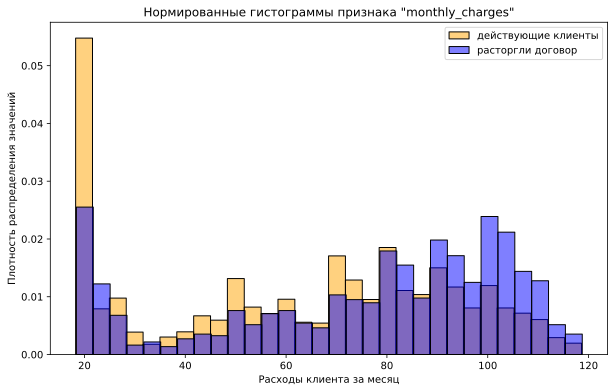

In [21]:
sb.histplot(df.loc[df['status'] == 1]['monthly_charges'],
        stat='density', bins=30, common_norm=False, alpha=0.5, color='orange', label='действующие клиенты')
sb.histplot(df.loc[df['status'] == 0]['monthly_charges'],
        stat='density', bins=30, common_norm=False, alpha=0.5, color='blue', label='расторгли договор')
plt.legend(loc='upper right')
plot_describe('Нормированные гистограммы признака "monthly_charges"',
              'Расходы клиента за месяц', 'Плотность распределения значений')

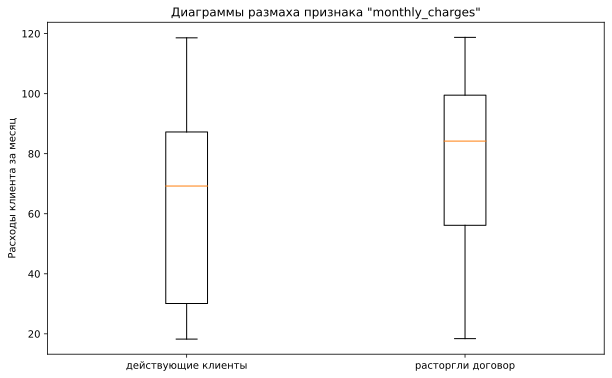

In [22]:
plt.boxplot([df.loc[df['status'] == 1]['monthly_charges'], 
            df.loc[df['status'] == 0]['monthly_charges']])
plt.xticks([1, 2], ['действующие клиенты', 'расторгли договор'])
plot_describe('Диаграммы размаха признака "monthly_charges"', '',
              'Расходы клиента за месяц')

**Промежуточный вывод:**

Выбросов и аномальных значений среди данного признака не обнаружено. По гистограммам различия между выборками заметить сложно, но зато диаграммы размаха более информативны: клиенты, расторгнувшие договор, в среднем платили заметно больше клиентов действующих, ввиду чего можно выдвинуть **первое предположение — слишком высокая ежемесячная плата может служить одним из факторов для принятия клиентом решения о расторжении договора.**

#### Признак `total_charges`

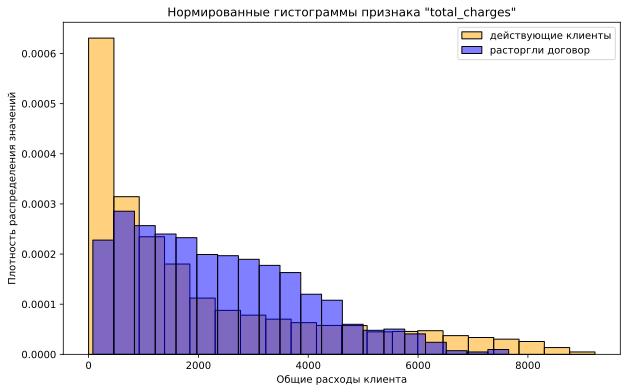

In [23]:
sb.histplot(df.loc[df['status'] == 1]['total_charges'],
        stat='density', bins=20, common_norm=False, alpha=0.5, color='orange', label='действующие клиенты')
sb.histplot(df.loc[df['status'] == 0]['total_charges'],
        stat='density', bins=20, common_norm=False, alpha=0.5, color='blue', label='расторгли договор')
plt.legend(loc='upper right')
plot_describe('Нормированные гистограммы признака "total_charges"',
              'Общие расходы клиента', 'Плотность распределения значений')

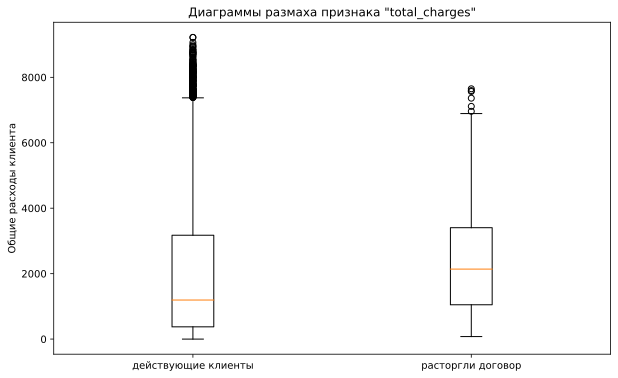

In [24]:
plt.boxplot([df.loc[df['status'] == 1]['total_charges'], 
            df.loc[df['status'] == 0]['total_charges']])
plt.xticks([1, 2], ['действующие клиенты', 'расторгли договор'])
plot_describe('Диаграммы размаха признака "total_charges"', '',
              'Общие расходы клиента')

Заметны выбросы на диаграммах размаха. Определим их долю от общего числа строк в датасете:

In [25]:
print(f'Доля строк с выбросами: {round(len(df.query("total_charges > 7300")) / len(df) * 100, 1)}%')

Доля строк с выбросами: 3.1%


**Промежуточный вывод:**

В данных обнаружены малочисленные выбросы, однако аномальных значений среди них не наблюдается. По гистограмме данного признака, равно как и предыдущего, можно заметить, что среди действующих пользователей довольно высока доля пользователей, использующих минимальный возможный платёж за услуги компании. При этом, косвенно подтверждается выдвинутая нами чуть ранее гипотеза: средние расходы ушедших пользователей почти вдвое превышают расходы пользователей оставшихся. Это может говорить о том, что недовольные ценовой политикой компании клиенты склонны к расторжению договора, и для их удержания необходимы какие-то дополнительные меры. 

В качестве таких мер могут выступать как специальные акции и персонализация предложений для клиентов, так и создание системы лояльности и повышение качества предоставляемых услуг.

#### Признак `duration`

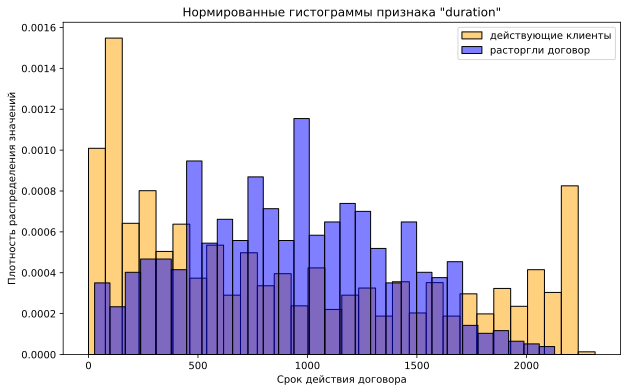

In [26]:
sb.histplot(df.loc[df['status'] == 1]['duration'],
        stat='density', bins=30, common_norm=False, alpha=0.5, color='orange', label='действующие клиенты')
sb.histplot(df.loc[df['status'] == 0]['duration'],
        stat='density', bins=30, common_norm=False, alpha=0.5, color='blue', label='расторгли договор')
plt.legend(loc='upper right')
plot_describe('Нормированные гистограммы признака "duration"',
              'Срок действия договора', 'Плотность распределения значений')

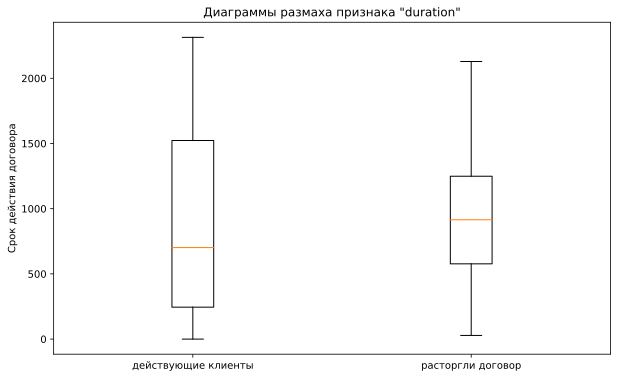

In [27]:
plt.boxplot([df.loc[df['status'] == 1]['duration'], 
            df.loc[df['status'] == 0]['duration']])
plt.xticks([1, 2], ['действующие клиенты', 'расторгли договор'])
plot_describe('Диаграммы размаха признака "duration"', '',
              'Срок действия договора')

In [28]:
print(f'Доля активных пользователей с продолжительностью договора не больше года:\
 {round(len(df.query("status == 1 and duration <= 365")) / len(df.query("status == 1")) * 100, 1)}%')

Доля активных пользователей с продолжительностью договора не больше года: 34.7%


**Промежуточный вывод:**

Выбросов и аномальных значений среди данного признака не обнаружено. По графикам можно сделать вывод о том, что пользователи, расторгнувшие договор, в большинстве своём были клиентами компании на протяжении 2-3 лет, в то время как среди действующих пользователей высока доля "свежих" клиентов, заключивших договор не более года тому назад (порядка 35 процентов).

### Категориальные признаки

Для категориальных признаков целесообразнее построить круговые диаграммы, показывающие соотношения между различными категориями. 

#### Признак `type`

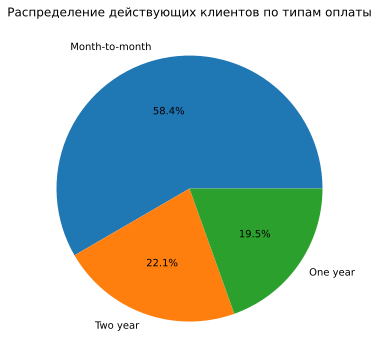

In [29]:
(df.loc[df['status'] == 1]['type'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение действующих клиентов по типам оплаты')
plt.show()

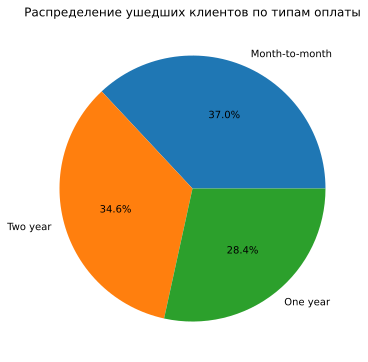

In [30]:
(df.loc[df['status'] == 0]['type'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение ушедших клиентов по типам оплаты')
plt.show()

**Промежуточный вывод:**

Среди ушедших клиентов заметно выше доли тех пользователей, которые производили оплату раз в один или два года. Сложно сделать какой-то однозначный вывод по одному этому признаку, поэтому попробуем рассмотреть остальные и сделаем вывод на основе общей картины. Пока же будем фиксировать только частные результаты.


#### Признак `paperless_billing`

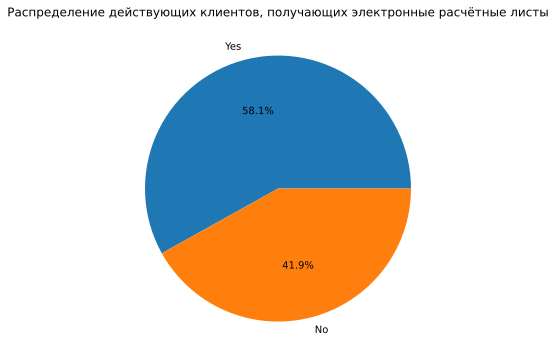

In [31]:
(df.loc[df['status'] == 1]['paperless_billing'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение действующих клиентов, получающих электронные расчётные листы')
plt.show()

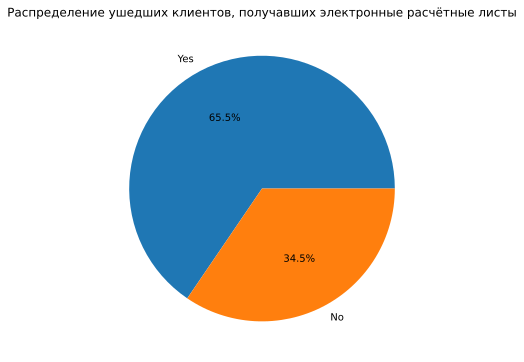

In [32]:
(df.loc[df['status'] == 0]['paperless_billing'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение ушедших клиентов, получавших электронные расчётные листы')
plt.show()

**Промежуточный вывод:**

Доли клиентов в подвыборках практически идентичны. К тому же, навряд ли получение или неполучение электронного расчётного листа могло бы отпугнуть пользователей, поэтому можем отнести этот признак к потенциально неинформативным.

#### Признак `payment_method`

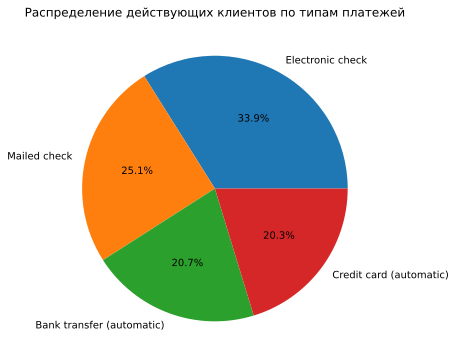

In [33]:
(df.loc[df['status'] == 1]['payment_method'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение действующих клиентов по типам платежей')
plt.show()

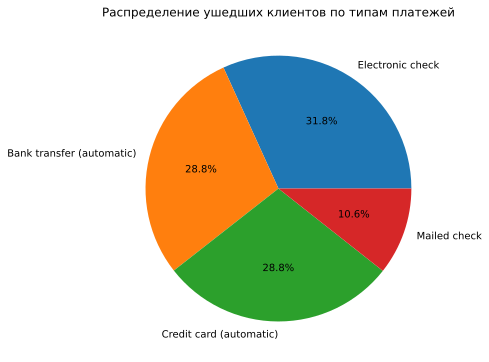

In [34]:
(df.loc[df['status'] == 0]['payment_method'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение ушедших клиентов по типам платежей')
plt.show()

**Промежуточный вывод:**

Среди оставшихся клиентов заметно выше доля оплачивающих услуги чеком по почте, среди ушедших — автоматически оплачивающих банковским переводом или кредитной картой.

#### Признак `gender`

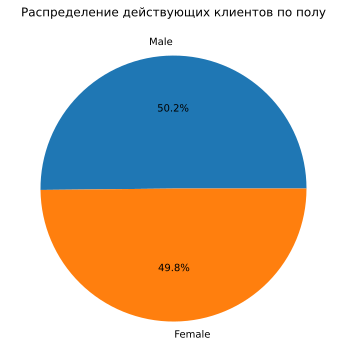

In [35]:
(df.loc[df['status'] == 1]['gender'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение действующих клиентов по полу')
plt.show()

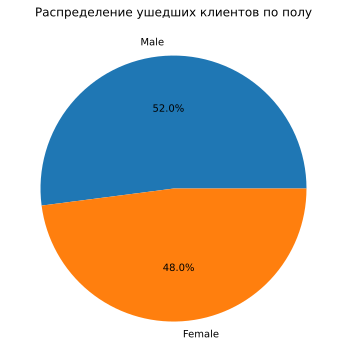

In [36]:
(df.loc[df['status'] == 0]['gender'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение ушедших клиентов по полу')
plt.show()

**Промежуточный вывод:**

Доли клиентов в подвыборках практически идентичны. В целом, это предсказуемо, признак можно отнести к неинформативным.

#### Признак `senior_citizen`

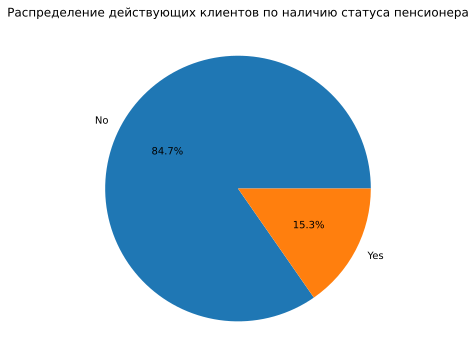

In [37]:
(df.loc[df['status'] == 1]['senior_citizen'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение действующих клиентов по наличию статуса пенсионера')
plt.show()

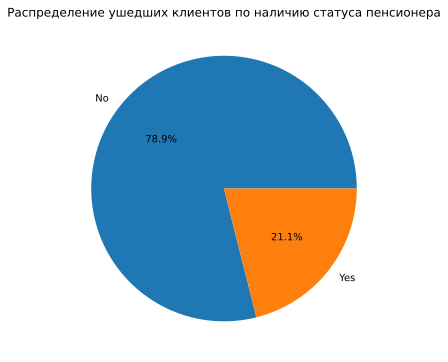

In [38]:
(df.loc[df['status'] == 0]['senior_citizen'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение ушедших клиентов по наличию статуса пенсионера')
plt.show()

**Промежуточный вывод:**

Доли клиентов в подвыборках практически идентичны. Это также предсказуемо, признак можно отнести к неинформативным.

#### Признак `partner`

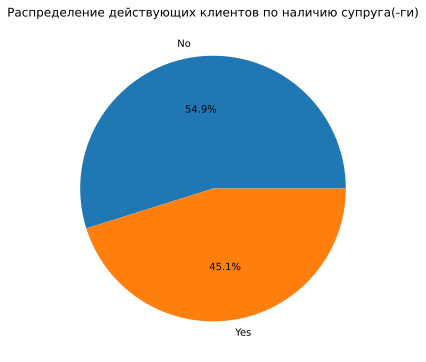

In [39]:
(df.loc[df['status'] == 1]['partner'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение действующих клиентов по наличию супруга(-ги)')
plt.show()

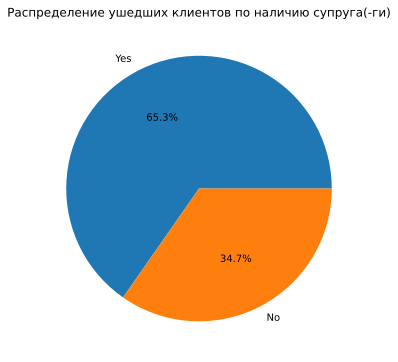

In [40]:
(df.loc[df['status'] == 0]['partner'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение ушедших клиентов по наличию супруга(-ги)')
plt.show()

**Промежуточный вывод:**

Среди активных клиентов заметно выше доля незамужних/неженатых, в то время как среди ушедших клиентов ситуация противоположная. Возможно, одной из причин оттока пользователей является акция для женатых пар, инициированная другой компанией, переманившей клиентов подобным образом, и "ТелеДому" стоит задуматься о введении подобной акции у себя.

#### Признак `dependents`

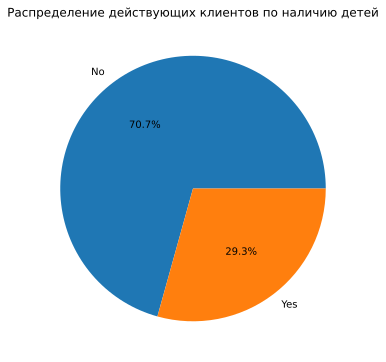

In [41]:
(df.loc[df['status'] == 1]['dependents'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение действующих клиентов по наличию детей')
plt.show()

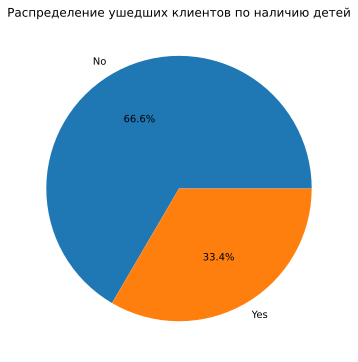

In [42]:
(df.loc[df['status'] == 0]['dependents'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение ушедших клиентов по наличию детей')
plt.show()

**Промежуточный вывод:**

А вот с детьми ситуация примерно та же, что и с пенсионными статусами — доли клиентов в подвыборках практически идентичны, ввиду чего признак можно отнести к неинформативным.

#### Признак `internet_service`

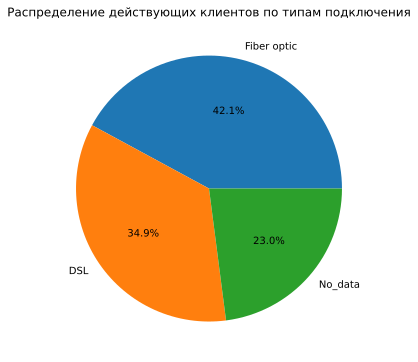

In [43]:
(df.loc[df['status'] == 1]['internet_service'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение действующих клиентов по типам подключения')
plt.show()

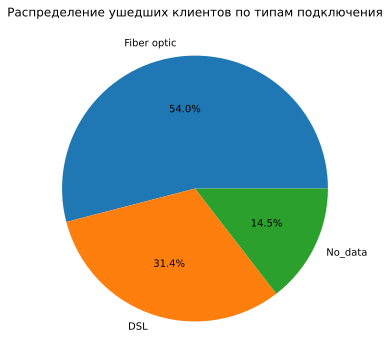

In [44]:
(df.loc[df['status'] == 0]['internet_service'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение ушедших клиентов по типам подключения')
plt.show()

**Промежуточный вывод:**

И вновь доли в подвыборках практически идентичны. Можно отметить, что среди разорвавших договор была бóльшая доля клиентов, использовавших оптоволоконную связь, чем среди клиентов оставшихся. Возможно, на их уход как-то повлияло ухудшение этой самой связи или изменения в ценовой политике компании.

#### Признак `online_security`

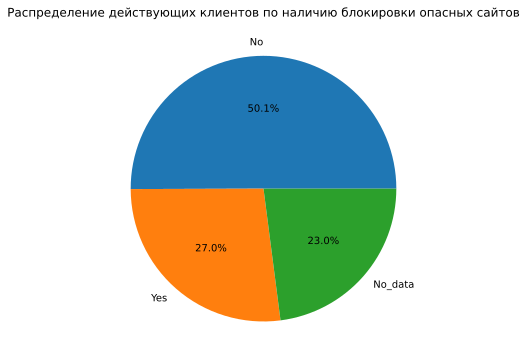

In [45]:
(df.loc[df['status'] == 1]['online_security'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение действующих клиентов по наличию блокировки опасных сайтов')
plt.show()

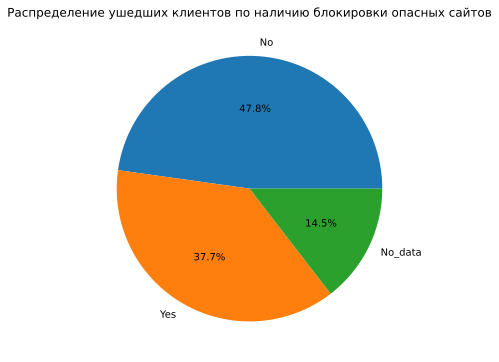

In [46]:
(df.loc[df['status'] == 0]['online_security'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение ушедших клиентов по наличию блокировки опасных сайтов')
plt.show()

**Промежуточный вывод:**

Доли клиентов в подвыборках практически идентичны. Среди ушедших выше доля тех, кто пользовался услугами по блокировке вредоносных сайтов, что наталкивает на мысль об ухудшении качества оказываемых услуг со временем (или переключением на оператора с лучшим качеством при неизменном в "ТелеДоме").

#### Признак `online_backup`

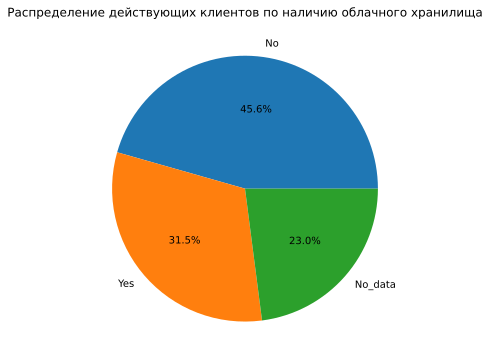

In [47]:
(df.loc[df['status'] == 1]['online_backup'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение действующих клиентов по наличию облачного хранилища')
plt.show()

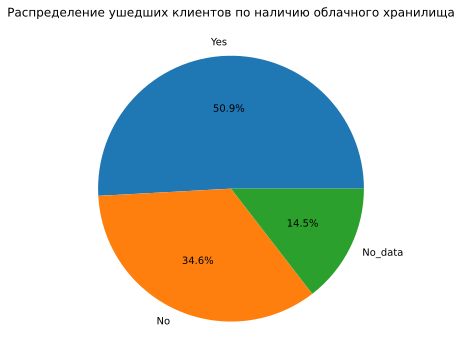

In [48]:
(df.loc[df['status'] == 0]['online_backup'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение ушедших клиентов по наличию облачного хранилища')
plt.show()

**Промежуточный вывод:**

Среди ушедших клиентов вновь выше доля тех, кто пользовался услугами облачного хранилища (по сравнению с клиентами оставшимися). Изучим другие признаки, относящиеся к интернет-соединению, прежде чем выдвинуть общую гипотезу на основе комплексного их рассмотрения.

#### Признак `device_protection`

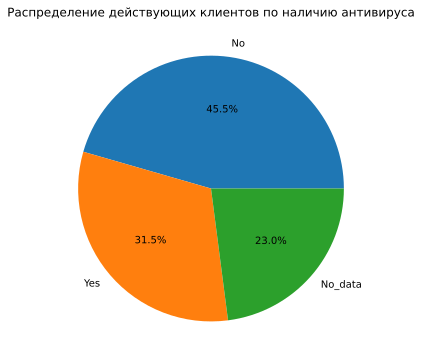

In [49]:
(df.loc[df['status'] == 1]['device_protection'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение действующих клиентов по наличию антивируса')
plt.show()

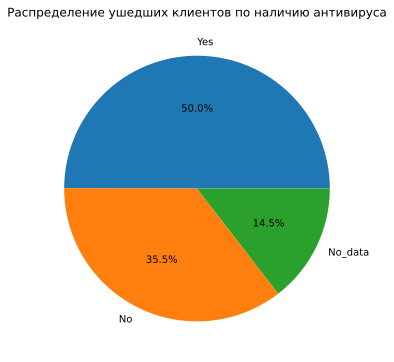

In [50]:
(df.loc[df['status'] == 0]['device_protection'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение ушедших клиентов по наличию антивируса')
plt.show()

**Промежуточный вывод:**

Среди ушедших клиентов выше доля тех, кто подключил антивирус (по сравнению с клиентами оставшимися).

#### Признак `tech_support`

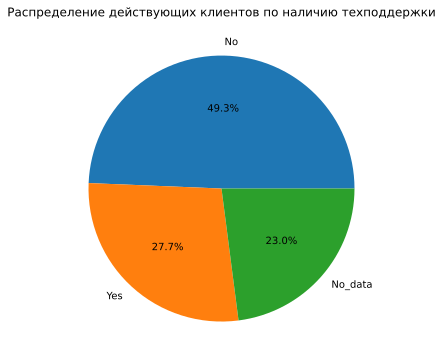

In [51]:
(df.loc[df['status'] == 1]['tech_support'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение действующих клиентов по наличию техподдержки')
plt.show()

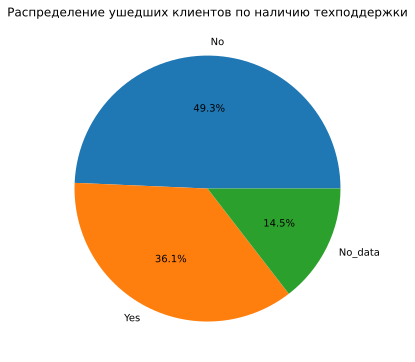

In [52]:
(df.loc[df['status'] == 0]['tech_support'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение ушедших клиентов по наличию техподдержки')
plt.show()

**Промежуточный вывод:**

На этот раз подвыборки практически идентичны, разве что чуть больше известно об ушедших пользователях (меньше доля `No_data`) и о том, что доля пользовавшихся услугами техподдержки среди них выше (хоть и незначительно).

#### Признак `streaming_tv`

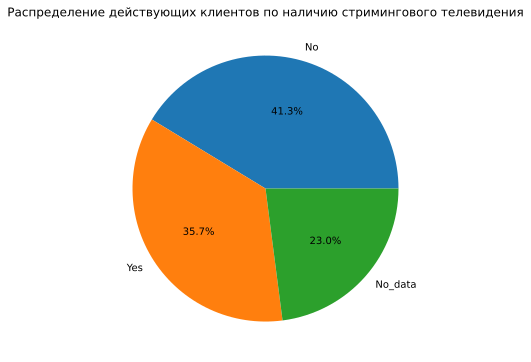

In [53]:
(df.loc[df['status'] == 1]['streaming_tv'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение действующих клиентов по наличию стримингового телевидения')
plt.show()

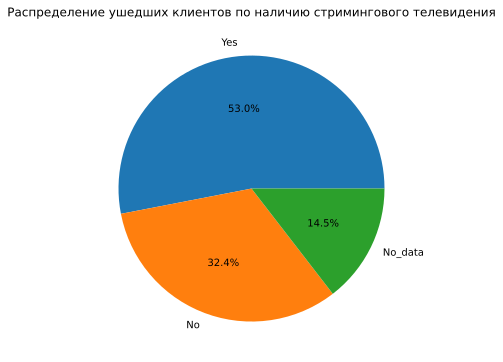

In [54]:
(df.loc[df['status'] == 0]['streaming_tv'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение ушедших клиентов по наличию стримингового телевидения')
plt.show()

**Промежуточный вывод:**

И вновь мы возвращаемся к ситуации, в которой среди ушедших клиентов заметно выше доля тех, кто пользовался рассматриваемой услугой. Данная тенденция с каждым новым таким признаком только укрепляет мысли о том, что клиенты могут уходить ввиду неудовлетворённости качеством оказываемых им услуг. 

#### Признак `streaming_movies`

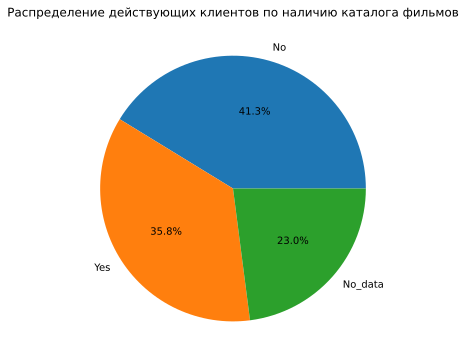

In [55]:
(df.loc[df['status'] == 1]['streaming_movies'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение действующих клиентов по наличию каталога фильмов')
plt.show()

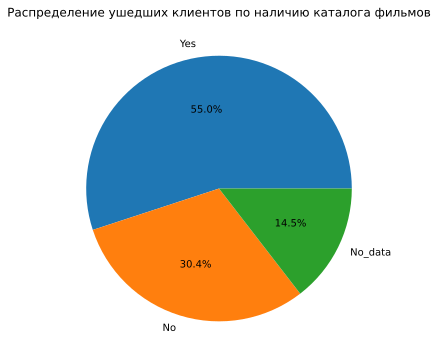

In [56]:
(df.loc[df['status'] == 0]['streaming_movies'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение ушедших клиентов по наличию каталога фильмов')
plt.show()

**Промежуточный вывод:**

Тенденция к уходу среди пользователей каталога фильмов снова чётко прослеживается.

#### Признак `multiple_lines`

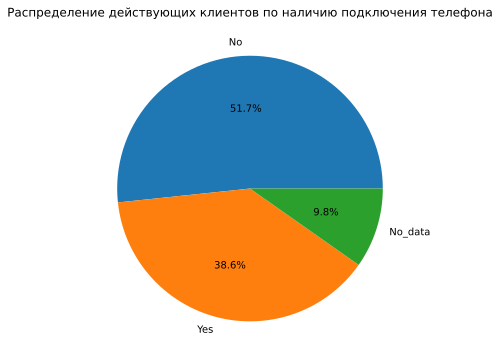

In [57]:
(df.loc[df['status'] == 1]['multiple_lines'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение действующих клиентов по наличию подключения телефона')
plt.show()

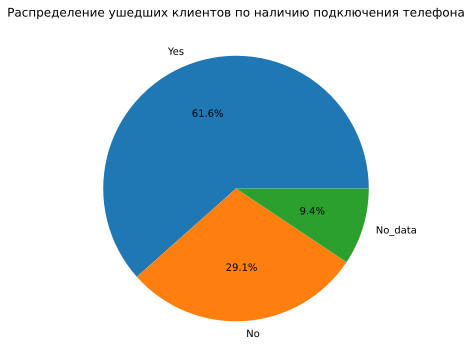

In [58]:
(df.loc[df['status'] == 0]['multiple_lines'].value_counts().plot(y='count', kind='pie', autopct='%1.1f%%', ylabel=''))
plt.title('Распределение ушедших клиентов по наличию подключения телефона')
plt.show()

**Промежуточный вывод:**

Среди ушедших пользователей довольно высок процент тех, кто пользовался услугами телефонии. Скорее всего это связано со снижением популярности данного способа связи в "эру смартфонов".

#### Признак `status`

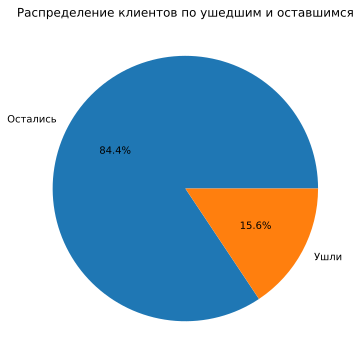

In [59]:
(df['status'].value_counts().plot(y='count', kind='pie', labels=['Остались', 'Ушли'], autopct='%1.1f%%', ylabel=''))
plt.title('Распределение клиентов по ушедшим и оставшимся')
plt.show()

**Промежуточный вывод:**

Доля ушедших клиентов сравнительно невысока по сравнению с клиентами активными, что свидетельствует о несбалансированности классов целевого признака. Однако, это не будет проблемой в рамках поставленной задачи, так как целевой метрикой в ней является ROC-AUC, нечувствительная к дисбалансу классов.

### Вывод по исследовательскому анализу и предобработке данных

В рамках **предобработки** мы привели названия всех столбцов к змеиному регистру, а также заменили "пустые" значения в столбце `total_charges` на нули. Все датасеты для удобства проведения анализа были объединены в один общий, для которого были удалены явные дубликаты и не обнаружены дубликаты неявные. Образовавшиеся в результате объединения пропуски ввиду сложной интерпретируемости их природы заменили значениями `No_data`. Также к объединённому датасету **были добавлены два признака — статус клиентского договора и срок его действия** (период времени, в течение которого клиенты пользовались услугами компании).

В рамках **исследовательского анализа** данные были разбиты на две подвыборки — тех клиентов, чьи договоры уже расторгнуты, и тех, чьи ещё нет, что помогло нам лучше понять влияние различных факторов на формирование целевого признака. Для каждого из количественных признаков была построена нормированная гистограмма и диаграмма размаха. Для категориальных признаков были построены круговые диаграммы, показывающие соотношения между различными категориями. 

На основе построенных графиков и диаграмм можно заключить следующее:

- Клиенты расторгнувшие договор с компанией в среднем платили заметно больше клиентов действующих. Это относится как к ежемесячным тратам, так и к общим расходам абонентов. Возможно, одной из причин их ухода стала именно ценовая политика компании.

- Средняя продолжительность срока действия договора у действующих пользователей ниже, чем у ушедших. К тому же, среди них много тех, кто является клиентом компании не больше года (порядка 35 процентов). Вероятно, это обусловлено тем, что ушедшие пользователи в какой-то момент разочаровались в ценовой политике компании или же в уровне предоставляемых ей услуг. Также, предоставляемые услуги (как, например, услуга телефонии) могли попросту устареть, а надобность в них — отпасть. 

- Действующие клиенты предпочитают ежемесячный тип оплаты, в противовес клиентам ушедшим, среди которых все три типа были актуальны в равной степени.

- Ряд признаков, таких как получение электронного расчётного листа, пол, семейное положение и прочие личные данные клиентов не играют значительной роли в принятии ими решения о расторжении договора, ввиду чего могут впоследствии считаться неинформативными и исключаться из рассмотрения.

- Практически для всех видов услуг наблюдается тенденция к снижению спроса и, как следствие, оттоку клиентов. Это также может подтверждать тезис о том, что услуги, предоставляемые компанией, либо теряют свою актуальность, либо оказываются не на должном уровне, либо другие компании оказывают их дешевле, и клиенты уходят к ним.

## Корреляционный анализ

Найдём коэффициенты корреляции между всеми признаками в объединённом датасете и отобразим их при помощи тепловой карты корреляций:

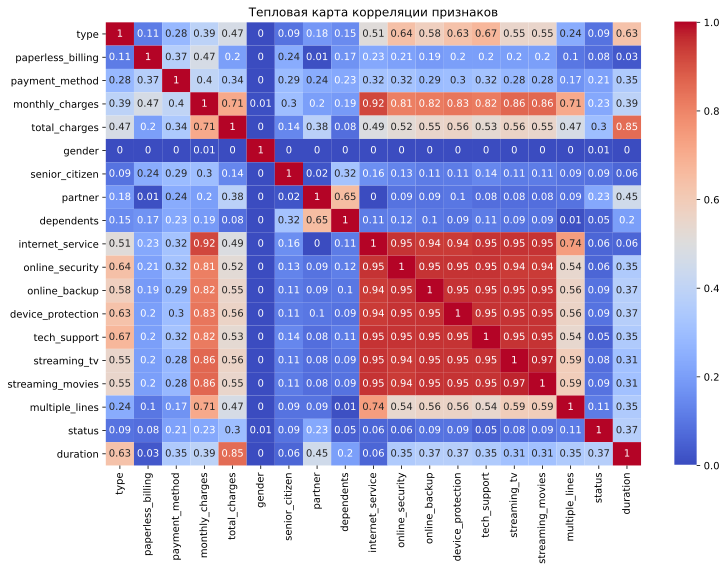

In [60]:
plt.figure(figsize=(12, 8))
sb.heatmap(df.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'duration']
    ).round(2), annot=True, vmin=0, vmax=1, cmap='coolwarm')
plot_describe('Тепловая карта корреляции признаков', '', '')

На основе матрицы корреляций можно судить о сильной корреляции между некоторыми входными признаками (например, между различными видами интернет-услуг), однако явных признаков сильной мультиколлинеарности (0.9 и более) с целевым признаком мы не наблюдаем.

Признаки, выделенные нами ранее как неинформативные, также показывают крайне низкую корреляцию с подавляющим большинством других признаков, поэтому попробуем исключить их из рассмотрения и построим тепловую карту корреляций заново. Также попробуем избавиться от мультиколлинеарности между различными интернет-услугами путём создания нового признака, который будет отражать число подключенных для каждого пользователя услуг:

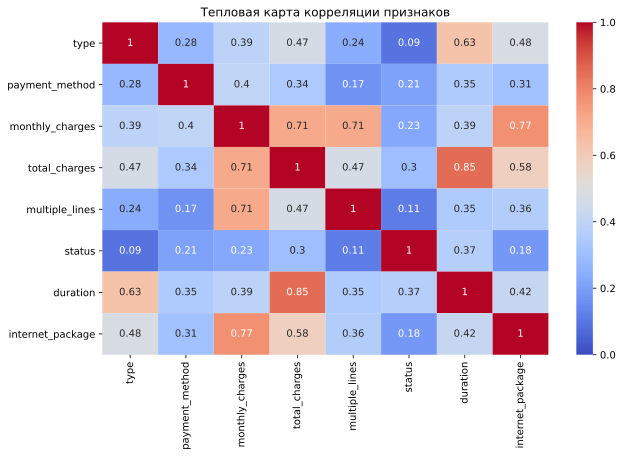

In [61]:
# Создаём новый признак
df['internet_package'] = (df[['internet_service', 'online_security', 'online_backup', 'device_protection', \
    'tech_support', 'streaming_tv', 'streaming_movies']]).apply(lambda row: (row == 'Yes').sum(), axis=1)
df = df.drop(['internet_service', 'online_security', 'online_backup', 'device_protection', \
    'tech_support', 'streaming_tv', 'streaming_movies'], axis=1)

# Избавляемся от неинформативных признаков
df = df.drop(['paperless_billing', 'gender', 'senior_citizen', 'partner', 'dependents', 'gender'], axis=1)

plt.figure(figsize=(10, 6))
sb.heatmap(df.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'duration']
    ).round(2), annot=True, vmin=0, vmax=1, cmap='coolwarm')
plot_describe('Тепловая карта корреляции признаков', '', '')

Наибольшая (хоть и довольно низкая сама по себе) корреляция с целевым признаком наблюдается у признаков, характеризующих ежемесячные и общие расходы клиентов, а также у признака, описывающего продолжительность действия договора.

## Подготовка данных для обучения

In [62]:
X = df.drop(['status'], axis = 1) 
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y,
        test_size = TEST_SIZE,
        random_state=RANDOM_STATE
    ) 

Для автоматизации машинного обучения (перебора вариантов масштабирования, выбора оптимальной модели и её гиперпараметров) в рамках данного анализа будем использовать пайплайны. Для кодирования категориальных признаков используем `OneHotEncoder`:

In [63]:
# Создаём списки с названиями признаков
ohe_columns = ['type', 'payment_method', 'multiple_lines']
num_columns = ['monthly_charges', 'total_charges', 'duration', 'internet_package']

# Cоздаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
   [  
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
       
    ]
)   

# Cоздаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [64]:
models = [] # Создаём пустые списки для таблицы результатов 
train_score = []

score_table = { # Создаём шаблон таблицы результатов
    'model': models,
    'cv_roc_auc': train_score,
}

In [65]:
def ml(model, params): # Прописываем функцию для обучения моделей
    pipeline = Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('model', model)
        ]
    )

    params = params

    search = RandomizedSearchCV(
        pipeline,
        params,
        scoring='roc_auc',
        random_state=RANDOM_STATE
    )

    search.fit(X_train, y_train)
    best_est = search.best_estimator_
    best_mod = search.best_estimator_['model']
    best_scr = search.best_score_
    models.append(best_mod) # Сохраняем результат модели
    train_score.append(best_scr)

    print("Лучшее значение метрики ROC-AUC:", search.best_score_)
    return best_est

## Обучение моделей машинного обучения

Обучим модели логистической регрессии, метода опорных векторов и k-ближайших соседей, алгоритмы деревьев решений и градиентного бустинга.

### Модель `LogisticRegression`

In [66]:
model_lr = LogisticRegression(random_state=RANDOM_STATE)
params_lr = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__solver': ['liblinear', 'saga'],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
}

best_est_lr = ml(model_lr, params_lr)

Лучшее значение метрики ROC-AUC: 0.7443456442843497


### Модель `SVC`

In [67]:
model_svc = SVC(random_state=RANDOM_STATE)
params_svc = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__kernel': ['linear', 'rbf', 'sigmoid'],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
}

best_est_svc = ml(model_svc, params_svc)

Лучшее значение метрики ROC-AUC: 0.7140342016844917


### Модель `KNeighborsClassifier`

In [68]:
model_kn = KNeighborsClassifier()
params_kn = {
    'model__n_neighbors': range(2, 21),
    'model__leaf_size': range(4, 31),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
}

best_est_kn = ml(model_kn, params_kn)

Лучшее значение метрики ROC-AUC: 0.7731461930970395


### Модель `DecisionTreeClassifier`

In [69]:
model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
params_dt = {
    'model__max_depth': range(2, 21),
    'model__max_features': range(2, 16)
}

best_est_dt = ml(model_dt, params_dt)

Лучшее значение метрики ROC-AUC: 0.7852130877939498


### Модель `LGBMClassifier`

In [70]:
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE)
params_lgbm = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.3],
}

best_est_lgbm = ml(model_lgbm, params_lgbm)

[LightGBM] [Info] Number of positive: 3555, number of negative: 668
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 4223, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.841819 -> initscore=1.671822
[LightGBM] [Info] Start training from score 1.671822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

### Модель `CatBoostClassifier`

In [71]:
model_cb = CatBoostClassifier(random_state=RANDOM_STATE)
params_cb = {
    'model__iterations': range(100, 3100, 100),
    'model__learning_rate': [0.01, 0.03, 0.1, 0.3],
    'model__depth': range(2, 6)
}

best_est_cb = ml(model_cb, params_cb)

0:	learn: 0.6869856	total: 138ms	remaining: 5m 30s
1:	learn: 0.6797859	total: 139ms	remaining: 2m 47s
2:	learn: 0.6737270	total: 141ms	remaining: 1m 52s
3:	learn: 0.6668251	total: 142ms	remaining: 1m 25s
4:	learn: 0.6605277	total: 144ms	remaining: 1m 8s
5:	learn: 0.6549552	total: 145ms	remaining: 57.9s
6:	learn: 0.6491292	total: 146ms	remaining: 50s
7:	learn: 0.6425044	total: 148ms	remaining: 44.2s
8:	learn: 0.6368355	total: 149ms	remaining: 39.7s
9:	learn: 0.6313089	total: 151ms	remaining: 36.1s
10:	learn: 0.6252828	total: 152ms	remaining: 33.1s
11:	learn: 0.6201376	total: 154ms	remaining: 30.6s
12:	learn: 0.6156628	total: 155ms	remaining: 28.5s
13:	learn: 0.6109419	total: 157ms	remaining: 26.7s
14:	learn: 0.6061358	total: 158ms	remaining: 25.1s
15:	learn: 0.6006632	total: 160ms	remaining: 23.8s
16:	learn: 0.5953199	total: 161ms	remaining: 22.6s
17:	learn: 0.5913386	total: 162ms	remaining: 21.5s
18:	learn: 0.5864435	total: 164ms	remaining: 20.5s
19:	learn: 0.5824439	total: 166ms	remai

## Выбор лучшей модели

Выведем полученные результаты в виде таблицы, в которой для каждой из рассмотренных моделей будут указаны наилучшее достигнутое значение метрики ROC-AUC, а также параметры, при которых данное значение было достигнуто:

In [72]:
scoring_table = pd.DataFrame(score_table)
scoring_table.sort_values(by='cv_roc_auc', ascending=False)

model  \
5                                        <catboost.core.CatBoostClassifier object at 0x00000220131F8280>   
4  LGBMClassifier(learning_rate=0.3, max_depth=3, n_estimators=200,\n               random_state=140725)   
3                              DecisionTreeClassifier(max_depth=7, max_features=14, random_state=140725)   
2                                                     KNeighborsClassifier(leaf_size=23, n_neighbors=17)   
0                                            LogisticRegression(C=1, random_state=140725, solver='saga')   
1                                                       SVC(C=0.1, kernel='linear', random_state=140725)   

   cv_roc_auc  
5    0.922827  
4    0.888166  
3    0.785213  
2    0.773146  
0    0.744346  
1    0.714034

По итогу перебора моделей и их гиперпараметров лучший результат на кросс-валидации показала модель CatBoostClassifier, поэтому в качестве итоговой модели выбираем её. Остаётся протестировать модель на тестовых данных:

In [73]:
y_predict = best_est_cb.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_predict)

0.9232959406548499

Проверим модель на адекватность при помощи `DummyClassifier`:

In [74]:
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)
dummy_preds = dummy_model.predict(X_test)
dummy_predict = dummy_model.predict_proba(X_test)[:, 1]
dummy_roc = roc_auc_score(y_test, dummy_predict)
print('ROC-AUC дамми-модели =', round(dummy_roc,2))

ROC-AUC дамми-модели = 0.5


Из этого можем заключить, что наша модель более чем адекватна.

**Промежуточный вывод:**

По итогу перебора моделей и их гиперпараметров лучшей моделью оказалась модель CatBoostClassifier. Метрика ROC-AUC на тестовой выборке составила 0.923, что соответствует заявленному критерию успешности (ROC-AUC > 0.85).

## Анализ ошибок

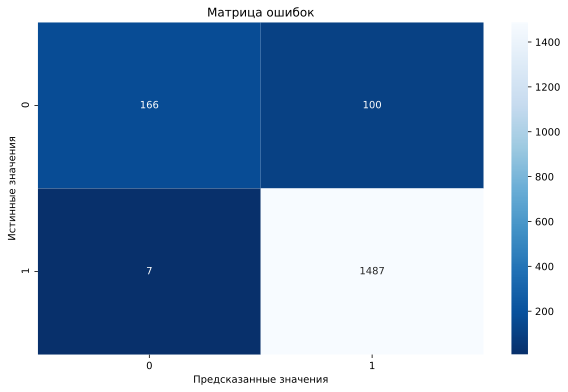

In [75]:
cm = confusion_matrix(y_test, np.round(y_predict)) # Построим матрицу ошибок
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plot_describe('Матрица ошибок', 'Предсказанные значения', 'Истинные значения')

**Промежуточный вывод:**

В модели присутствуют 7 ошибок второго рода при 1487 верноположительных предсказаниях. В рамках решаемой задачи такие ошибки критичнее всего, так как ведут к уходу клиента, которого компания потенциально считала лояльным. Однако, их количество настолько невелико в масштабах остальных предсказаний, что менять какие-либо параметры модели для оптимизации количества таких ошибок представляется нецелесообразным в рамках данной задачи.

## Анализ важности признаков

Лучшей моделью оказалась CatBoostClassifier, однако она сложна в интерпретации. Поэтому на данном этапе мы рассмотрим степень влияния различных признаков на итоговое предсказание, и найдём те из них, которые вносят наибольший и наименьший вклад. Для этого отберём наиболее влиятельные признаки и отсортируем их по убыванию значимости:

In [76]:
model = best_est_cb['model']
preprocessor = best_est_cb.named_steps['preprocessor']
X_train_scalled = preprocessor.transform(X_train)
feature_names = best_est_cb[:-1].get_feature_names_out()
df_shap = pd.DataFrame(X_train_scalled, columns=feature_names)

explainer = shap.TreeExplainer(model, df_shap)
shap_values = explainer.shap_values(df_shap)

 96%|=================== | 5084/5279 [00:21<00:00]       

Построим несколько графиков, изображающих среднее значение вклада каждого признака в предсказание при помощи значений Шепли (SHAP):

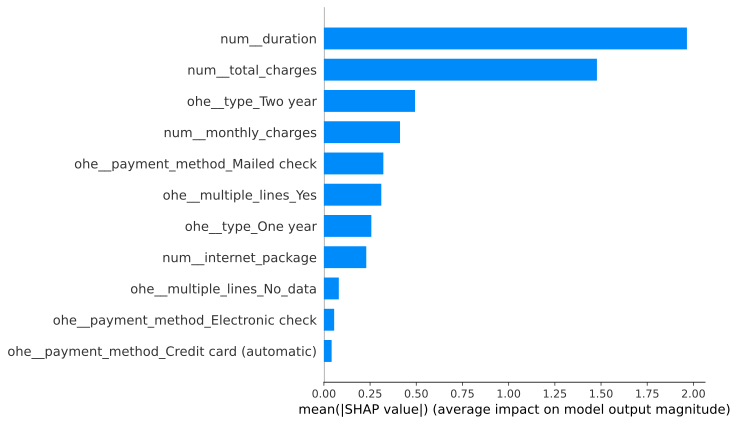

In [77]:
fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize=14)
ax.set_title('Вклад признаков в прогноз модели', fontsize=16)

cb_ax = fig.axes[0] 
cb_ax.tick_params(labelsize=12)
cb_ax.set_ylabel('Название признака', fontsize=16)

shap.summary_plot(shap_values, X_train_scalled, feature_names=feature_names,
    plot_type="bar", max_display=11, plot_size=[10, 6])

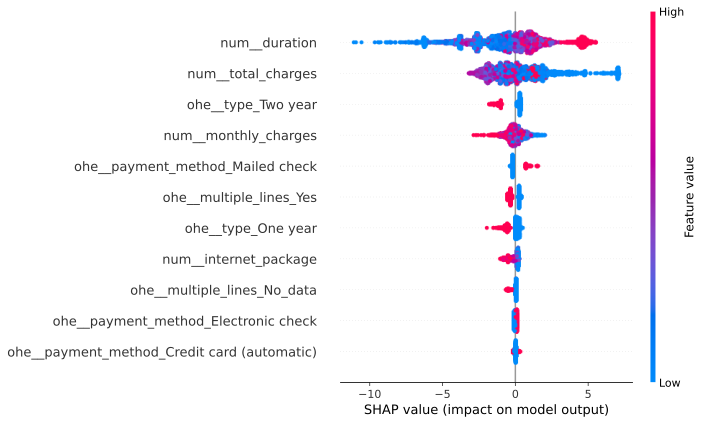

In [78]:
fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize=14)
ax.set_title('Вклад признаков в прогноз модели', fontsize=16)

cb_ax = fig.axes[0] 
cb_ax.tick_params(labelsize=12)
cb_ax.set_ylabel('Название признака', fontsize=16)

shap.summary_plot(shap_values, X_train_scalled, feature_names=feature_names, max_display=11, plot_size=[10, 6])

Наибольший вклад в прогнозирование вносят признаки:
- срок действия договора (период времени, в течение которого клиенты пользовались услугами компании);
- общие и ежемесячные расходы абонентов.

Наименьший вклад в прогнозирование вносят признаки:
- оплата электронным чеком или кредитной картой;
- подключение интернет-услуг или телефонии.

**Промежуточный вывод:**

Анализ важности признаков подтвердил некоторые предположения, выдвинутые на основе исследовательского анализа — а именно тот факт, что желание клиента расторгнуть договор будет тем выше, чем выше будут его ежемесячные и общие расходы. Также в сторону принятия решения об уходе пользователей, хоть и незначительно, но подталкивают оказываемые им услуги интернета и телефонии, что может подтверждать выдвинутую ранее гипотезу о снижении качества оказываемых компанией услуг или же их невыгодности на фоне предложений конкурентов на рынке. 

При этом есть и расхождения с предварительными выводами — согласно анализу признаков, лояльность клиента тем выше, чем дольше срок его договора. 

Исходя из вышеперечисленного, можно сформулировать **рекомендации для компании**:

- Во-первых, "ТелеДому" стоит **оптимизировать структуру тарифов** и предложить более гибкие варианты для клиентов. Это может включать в себя создание пакетов, в которых абоненты смогут выбирать только те услуги, которые им действительно необходимы, а не переплачивать за ненужные функции.


- Во-вторых, может помочь **внедрение программы лояльности**. Например, компания могла бы предложить скидки или бонусы за долгосрочное сотрудничество, что будет поощрять клиентов оставаться с ней дольше.


- В-третьих, важно задуматься об **улучшении маркетинга**, чтобы быть более прозрачными в предложениях и условиях. Например, стоит делать акцент на том, как клиенты могут экономить, выбирая услуги "ТелеДома", а не конкурентов.

## Общий вывод и рекомендации заказчику

В ходе работы над проектом была **обучена модель, прогнозирующая отток клиентов из компании "ТелеДом"**. Наилучшие показатели целевой метрики ROC-AUC на тренировочной выборке показала **модель CatBoostClassifier**, в связи с чем обучение на тестовой выборке было проведено на ней. **Итоговое значение целевой метрики — 0,923**, что соответствует заявленному критерию успешности (ROC-AUC > 0.85).

Также **на основе исследовательского анализа и анализа важности признаков** при помощи значений Шепли (SHAP) были сделаны следующие **выводы**: 

- Лояльность клиента тем выше, чем дольше срок его договора.

- Лояльность клиента тем ниже, чем выше его ежемесячные и общие расходы. К тому же, в сторону принятия решения об уходе пользователей подталкивают оказываемые им услуги интернета и телефонии, что может свидетельствовать о снижении качества оказываемых компанией услуг или же их невыгодности на фоне предложений конкурентов на рынке. 

Исходя из вышеперечисленного, были сформулированы **рекомендации для компании**:

- Во-первых, "ТелеДому" стоит **оптимизировать структуру тарифов** и предложить более гибкие варианты для клиентов. Это может включать в себя создание пакетов, в которых абоненты смогут выбирать только те услуги, которые им действительно необходимы, а не переплачивать за ненужные функции.


- Во-вторых, может помочь **внедрение программы лояльности**. Например, компания могла бы предложить скидки или бонусы за долгосрочное сотрудничество, что будет поощрять клиентов оставаться с ней дольше.


- В-третьих, важно задуматься об **улучшении маркетинга**, чтобы быть более прозрачными в предложениях и условиях. Например, стоит делать акцент на том, как клиенты могут экономить, выбирая услуги "ТелеДома", а не конкурентов.

Остановимся подробнее на основных итогах исследования.

Изначально проблем при выгрузке данных не возникло, не было обнаружено пропусков. Однако, в названиях столбцов были допущены стилистические ошибки.

В рамках **предобработки данных** мы привели названия всех столбцов к змеиному регистру, а также заменили "пустые" значения в столбце `total_charges` на нули. Все датасеты для удобства проведения анализа были объединены в один общий, для которого были удалены явные дубликаты и не обнаружены дубликаты неявные. Образовавшиеся в результате объединения пропуски ввиду сложной интерпретируемости их природы заменили значениями `No_data`. Также к объединённому датасету **были добавлены два признака — статус клиентского договора и срок его действия** (период времени, в течение которого клиенты пользовались услугами компании). Признак статуса договора был выделен как целевой в рамках дальнейшего исследования.

В рамках **исследовательского анализа** данные были разбиты на две подвыборки — тех клиентов, чьи договоры уже расторгнуты, и тех, чьи ещё нет, что помогло нам лучше понять влияние различных факторов на формирование целевого признака. Для каждого из количественных признаков была построена нормированная гистограмма и диаграмма размаха. Для категориальных признаков были построены круговые диаграммы, показывающие соотношения между различными категориями. 

На этапе **корреляционного анализа** были удалены малоинформативные признаки (как, например, пол, наличие детей или статуса пенсионера и т. п.) ввиду крайне низкой их корреляции как друг с другом, так и с целевым признаком. Также было принято решение избавиться от мультиколлинеарности между различными интернет-услугами путём создания нового признака, отражающего число подключенных для каждого пользователя услуг. При этом наибольшая (хоть и довольно низкая сама по себе) корреляция с целевым признаком наблюдалась у признаков, характеризующих ежемесячные и общие расходы клиентов, а также у признака, описывающего продолжительность действия договора. 

Для автоматизации машинного обучения (перебора вариантов масштабирования, выбора оптимальной модели и её гиперпараметров) в рамках данного анализа были использованы пайплайны. 

Были обучены модели логистической регрессии, метода опорных векторов и k-ближайших соседей, алгоритмы деревьев решений и градиентного бустинга. **Лучшей моделью на кросс-валидации оказалась CatBoostClassifier** со значением целевой метрики ROC-AUC на тренировочной выборке равной 0,92, в связи с чем обучение на тестовой выборке также проводилось на ней. 

На основе обученной модели была составлена матрица ошибок, по которой было определено, что в модели присутствуют 7 ошибок второго рода при 1487 верноположительных предсказаниях. В рамках решаемой задачи такие ошибки выделены как наиболее критичные, так как они ведут к уходу клиента, которого компания потенциально считала лояльным. Однако, их количество оказалось настолько невелико в масштабах остальных предсказаний, что менять какие-либо параметры модели для оптимизации количества таких ошибок оказалось нецелесообразным.

В конце концов, была рассмотрена степень влияния различных признаков на итоговое предсказание и найдены те из них, которые вносят наибольший и наименьший вклад. Для этого были построены несколько графиков, изображающих среднее значение вклада каждого признака в предсказание при помощи значений Шепли (SHAP). В результате данного анализа было определено, что наибольший вклад в прогнозирование вносят такие признаки как срок действия договора (период времени, в течение которого клиенты пользовались услугами компании) и общие и ежемесячные расходы абонентов. Наименьший же вклад в прогнозирование вносят такие признаки как оплата электронным чеком или кредитной картой, а также подключение интернет-услуг или телефонии.